In [327]:
import geopandas as gpd
import duckdb
from graph_tool.all import Graph, remove_parallel_edges, GraphView
from graph_tool.draw import graph_draw
from graph_tool.centrality import eigenvector
from graph_tool import load_graph, show_config
from graph_tool.topology import label_components, extract_largest_component
import numpy as np
import pandas as pd
import gzip
from tqdm import tqdm

# TILE CODING

In [30]:
with gzip.open('../data/transmission_lines.geojson.gz', 'rt') as f:
    gdf = gpd.read_file(f)

In [31]:
exploded = gdf.explode().reset_index().drop(['level_0', 'level_1'], axis=1)

/var/folders/3n/qtttn0wx3qv7fwkq55qhm2cm0000gn/T/ipykernel_12316/3017378427.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  exploded = gdf.explode().reset_index().drop(['level_0', 'level_1'], axis=1)


In [32]:
usa = exploded.cx[-130:-40, 25:55]

In [33]:
usa['coords_one'] = usa['geometry'].apply(lambda x: ', '.join(map(str, (x.coords[0][1], x.coords[0][0])))) # We need to reverse the coords
usa['coords_two'] = usa['geometry'].apply(lambda x: ', '.join(map(str, (x.coords[-1][1], x.coords[-1][0])))) # The GeoJSON has flipped coords

/Users/cyruskirby/opt/miniconda3/envs/transmission_grid/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/cyruskirby/opt/miniconda3/envs/transmission_grid/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [34]:
usa.columns = [c.lower() for c in usa.columns]

#### Goal

|objectid|coord1|coord2|

1. Find all coords that appear only once, and find the object they're attached to. (join coords to usa)
2. Find all subs that appear only once, and find the object they're attached to. (join subs to usa)
3. Find 


OR 

1. Find all coords and all subs
2. Find edges associated with those coords and subs 
3. 
4. 

### Create a vertices table

| vertex_id | coord | name | type |
|-----------|-------|------|------|
| 1 | -89.9, 30.4   | S331 | substation |

Create it from the lines_raw table by doing the following:

create coords_raw table by finding distinct coords from lines table
| coord_id | coord |
|----------|-------|
| 1  | -89.9, 30.4 |

create subs_raw table by finding distinct subs from lines table

| sub_id | sub_name |
|--------|----------|
| 1      | S331     |

Find substations associated with coords by:
1. joining coords table to lines table on coord 1, then coord 2, selecting sub 1, coord1 and sub 2, coord2
2. union the result, getting a table with distinct substation names and coords
3. ^ not quite right because some coords are phantom coords - they are ever so slightly off from their true value, and should be replaced with whatever coord existing lines have at the shared substation

Step 1: Determine substation coords:
1. join subs table to lines table twice, on sub_name = sub_1 then sub_name = sub_2, selecting coords and subs
2. exclude substations that = "NOT AVAILABLE"
3. union the result
4. select sub and the coord with most connections. If count is 1, then AVG(coords)
5. create a new subs table with this information

^ What about unknown substations ("NOT AVAILABLE") that should be repaired via coords-matching?
We want to generate new station names and coords.

Step 2: 
1. SELECT sub_1, coords_one from lines WHERE sub_1 = 'NOT AVAILABLE' UNION SELECT coords_two from lines WHERE sub_two = 'NOT AVAILABLE'

Identify and fix lines that share a substation but have different coords:





Types of vertices, in decreasing quality:
Derived from edge(s), ...
- whose substations are the same and coordinates are the same (BEST).
- some substations are nonexistent but the rest are the same, and their coordinates are the same (GOOD).
- whose substations are nonexistent but their coordinates are the same (GOOD). In this case, create a new substation with the common coords
- whose coordinates are different but share a substation (FINE). In this case, impute coords by the most common if one coord appears more than once, or the mean.
- whose coordinates are different and don't share a substation (TERRIBLE). In this case, I might have to infer that a substation exists where edges terminate within $\epsilon_1$-tolerance AND there isn't another substation within $\epsilon_2$-tolerance. This might be error-prone and unnecessary.

Create the vertices table by going down the list

## NEW PLAN

1. Find all edges associated with each substation. 
2. Count the appearances of each coordinate across the edges
3. Filter to coords with COUNT > 1 (because COUNT = 1 means an edge on the opposite end of line)
4. Verify that the coords are nearby each other
5. If all is good, take the average of these coords and...
6. Make an entry in the vertices table with the substation name
7. Else, cry

In [79]:
pd.concat([usa['coords_one'], usa['coords_two']]).drop_duplicates().shape

(74199,)

In [36]:
sql_df = usa.drop('geometry', axis=1)
with duckdb.connect('transmission.db') as con:
    con.sql('INSTALL spatial; LOAD spatial;')
    con.sql('DROP TABLE IF EXISTS usa')
    con.sql('DROP TABLE IF EXISTS lines')
    con.sql('CREATE TABLE lines AS SELECT * FROM sql_df')

Is it a good idea to repeatedly remove one-degree nodes to simplify the graph representation? These should be unimportant points.

### How is the following logic supposed to work?

Context: We need to identify vertices for our vertex-edge graph representation of the transmissions grid.
Problem: To distinguish vertices that are close together, we need to use a combination of substation names and coordinates. As multiple substations can share a name, multiple substations can be near each other with different names, a single substation can fail to have common coordinates because of data quality issues, coordinates can connect but incorrectly not share a substation name, and we only have access to edge-level data (which contains name and coord information about their endpoints but the connection isn't indicated at row-level data), this is quite complex.

Examples of problem nodes:
PINEVILLE.png, which is a large substation and has transmission lines connecting to it at two different coordinates. This substation should be classified as one vertex on our graph, and each edge that connects to either of the two points should connect to the one vertex.
MIDWAY, which is a name that belongs to 3(?) substations across the US. 
some random point in the Louisiana islands has three points which should connect but don't their coordinates don't quite meet. 

Solution: Round each substation's coordinates to 2 decimal points and COUNT the lines that have it as an endpoint. This will turn cases like PINEVILLE into a single substation. From this level of precision, there are still some coordinates that are very near to each other yet not grouped together, so there's still the question of which one corresponds to the substation. These could be the other ends of the transmission lines or other parts of the substation. So, we need to aggregate each substation's coordinates to 1 decimal point and COUNT because that is coarse enough to group all of these possibilities together into one point. Join these two views together on substation and coordinates rounded to 1 decimal point and calculate the two COUNTs from before. The proper substation coordinate is the coordinate in the row with the highest COUNT for each substation-coarse-coordinate combo. 

Result: This isn't quite right because some substations that have two coordinates have many connections to both coordinates, so though each connection is a plurality they are not majorities (see CHESTERFIELD.png). I might need to have a more clever aggregation system than simply rounding. This is furthered by the fact that some stations that are very close together simply aren't being rounded together as I'd like them to because ROUND is too simple an algorithm. For example, rounding to the tens place would put 34.9 and 35.1 in different bins, rounding to the nearest 5 would put 37.51 and 37.48 in different bins, and so on. I'm thinking of using a dual-bin system, where I make bins of coord-subs rounded to the nearest 2 and the nearest 1, and make a 2-part decision. If coord-sub combos are placed in different ones bins yet the same twos bin, then they go together, and if they go in the same ones bin they go together. Still this seems to be sus in cases on the edge, e.g. 37.1 and 38.9 would be placed in the 38s bin, but maybe they're too far apart? Perhaps I just need smaller bins.  

In [127]:
with duckdb.connect('transmission.db') as con:
    con.sql('INSTALL spatial; LOAD spatial;')
    con.sql("""
            CREATE TEMPORARY TABLE coords_subs_combos AS (
                SELECT
                    id as line_id
                    , coords_one::varchar               AS coords
                    , ST_Point(
                        CAST(SPLIT_PART(coords_one, ', ', 1) AS FLOAT),
                        CAST(SPLIT_PART(coords_one, ', ', 2) AS FLOAT)
                    )                                   AS geom
                    , sub_1                             AS sub
                FROM
                    lines
                UNION
                SELECT
                    id
                    , coords_two
                    , ST_Point(
                        CAST(SPLIT_PART(coords_two, ', ', 1) AS FLOAT),
                        CAST(SPLIT_PART(coords_two, ', ', 2) AS FLOAT)
                    )
                    , sub_2
                FROM
                    lines
                UNION
                SELECT
                    id
                    , coords_one
                    , ST_Point(
                        CAST(SPLIT_PART(coords_one, ', ', 1) AS FLOAT),
                        CAST(SPLIT_PART(coords_one, ', ', 2) AS FLOAT)
                    )
                    , sub_2
                FROM
                    lines
                UNION
                SELECT 
                    id
                    , coords_two
                    , ST_Point(
                        CAST(SPLIT_PART(coords_two, ', ', 1) AS FLOAT),
                        CAST(SPLIT_PART(coords_two, ', ', 2) AS FLOAT)
                    )
                    , sub_1
                FROM
                    lines
            );

            CREATE INDEX idx_coords ON coords_subs_combos (sub, coords, geom);

                """)
    
    con.sql("""            
            CREATE TEMPORARY VIEW lat_lons AS 
            SELECT 
                sub
                , SPLIT_PART(
                    coords
                    , ', '
                    , 1
                )::DOUBLE                      AS lat
                , SPLIT_PART(
                    coords
                    , ', '
                    , 2
                )::DOUBLE                      AS lon
                , coords
                , line_id
            FROM
                coords_subs_combos""")
    
    con.sql("""
            CREATE TEMPORARY VIEW agged_coords_fine AS
            SELECT
                sub
                , ROUND(lat, 1)                   AS lat_fine
                , ROUND(lon, 1)                   AS lon_fine
                , COUNT(*)              AS num_lines_fine
            FROM 
                lat_lons
            GROUP BY
                sub
                , ROUND(lat, 1)
                , ROUND(lon, 1);
            
            CREATE TEMPORARY VIEW agged_coords_coarse AS 
            SELECT
                sub
                , ROUND(lat / 2.5) * 2.5             AS lat_coarse
                , ROUND(lon / 2.5) * 2.5             AS lon_coarse
                , COUNT(*)                  AS num_lines_coarse
            FROM
                lat_lons        
            GROUP BY
                sub
                , ROUND(lat / 2.5) * 2.5
                , ROUND(lon / 2.5) * 2.5;
            
            CREATE TEMPORARY VIEW dominance AS
            SELECT
                fine.sub
                , fine.lat_fine
                , fine.lon_fine
                , crse.lon_coarse
                , crse.lat_coarse
                , fine.num_lines_fine
                , crse.num_lines_coarse
                , fine.num_lines_fine / crse.num_lines_coarse AS dominance
            FROM
                agged_coords_fine fine
            JOIN
                agged_coords_coarse crse
            ON
                crse.sub = fine.sub
            AND 
                crse.lon_coarse = ROUND(fine.lon_fine / 2.5) * 2.5
            AND 
                crse.lat_coarse = ROUND(fine.lat_fine / 2.5) * 2.5
            GROUP BY
                fine.sub
                , fine.lat_fine
                , fine.lon_fine
                , crse.lon_coarse
                , crse.lat_coarse
                , fine.num_lines_fine
                , crse.num_lines_coarse
            HAVING 
                fine.num_lines_fine / crse.num_lines_coarse >= 0.5
            ORDER BY
                num_lines_coarse DESC;
            """)
    
    df_fine = con.sql("""SELECT * FROM agged_coords_fine""").df()
    df_coarse = con.sql("""SELECT * FROM agged_coords_coarse""").df()
    dominance = con.sql("""SELECT * FROM dominance""").df()

In [133]:
filter_subs(usa, 'BENTON')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
587,588,142504,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-06-05 00:00:00+00:00,IMAGERY,2018-05-31 00:00:00+00:00,...,500.0,500,Y,BENTON,NOT AVAILABLE,{6341F3FD-D09E-43E5-9F56-44383879C3F8},0.006771,"LINESTRING (-89.20036 34.82898, -89.20114 34.8...","34.8289766, -89.2003575","34.8353146, -89.2018559"
3379,3379,145108,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, KCC Electric Certified...",2014-10-07 00:00:00+00:00,IMAGERY,2014-12-17 00:00:00+00:00,...,138.0,100-161,N,UNKNOWN118017,BENTON,{D1726EE4-8BC5-4DEF-93B2-7457BAF33634},0.068733,"LINESTRING (-97.19852 37.73843, -97.19842 37.7...","37.73843, -97.1985215","37.7911283, -97.1689612"
4002,4002,145920,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.mngeo.state...",2015-07-29 00:00:00+00:00,IMAGERY,2015-09-24 00:00:00+00:00,...,230.0,220-287,N,UNKNOWN129693,BENTON,{448A4CB2-8D56-4FEA-BB46-6A260B7C6FD7},0.488078,"LINESTRING (-94.03844 45.56885, -94.03768 45.5...","45.5688516, -94.0384392","45.7552726, -93.6385334"
12826,12826,101539,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, KCC Electric Certified...",2014-10-07 00:00:00+00:00,IMAGERY,2018-11-09 00:00:00+00:00,...,138.0,100-161,N,UNKNOWN118012,BENTON,{DA2ECAE6-57EB-47B6-8A6B-72565476871D},0.176863,"LINESTRING (-97.16896 37.79113, -97.17048 37.7...","37.7911283, -97.1689612","37.7922093, -97.3444413"
12909,12909,112919,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, KCC Electric Certified...",2014-10-07 00:00:00+00:00,IMAGERY,2018-11-13 00:00:00+00:00,...,138.0,100-161,N,UNKNOWN118990,BENTON,{B2E2C539-339A-40A1-AE5D-0A49B88E760C},0.254629,"LINESTRING (-97.16896 37.79113, -97.16969 37.7...","37.7911283, -97.1689612","37.824262, -96.9248453"
14769,14768,145558,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.oatioasis.c...",2014-07-25 00:00:00+00:00,IMAGERY,2019-03-26 00:00:00+00:00,...,161.0,100-161,Y,BENTON,TAP152016,{112E03B4-E941-485C-B106-1A0DE36CD880},0.000913,"LINESTRING (-84.64500 35.18331, -84.64448 35.1...","35.183308, -84.6449971","35.1839868, -84.6443995"
17392,17391,166724,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.atcllc.com/wp-content/uplo...",2018-08-29 00:00:00+00:00,IMAGERY,2018-09-19 00:00:00+00:00,...,69.0,UNDER 100,Y,MINER,BENTON,{0CE79356-5ADB-406E-A669-B693793497E6},0.148231,"LINESTRING (-90.29460 42.56216, -90.29458 42.5...","42.5621645, -90.2945978","42.5730184, -90.4067247"
17393,17392,166725,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.atcllc.com/wp-content/uplo...",2018-08-29 00:00:00+00:00,IMAGERY,2018-09-19 00:00:00+00:00,...,69.0,UNDER 100,Y,BENTON,TAP162984,{B6B1314A-FF9C-4D6F-BF06-DD7EAE328287},0.021631,"LINESTRING (-90.40672 42.57302, -90.40661 42.5...","42.5730184, -90.4067247","42.594619, -90.406808"
18512,18511,101122,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.mngeo.state...",2015-08-24 00:00:00+00:00,IMAGERY,2015-09-24 00:00:00+00:00,...,345.0,345,N,BENTON,SHERBURNE COUNTY,{5B035321-EF89-4FB3-9AEC-CFCF5A25E0A7},0.360780,"LINESTRING (-93.89807 45.37485, -93.89741 45.3...","45.3748523, -93.8980659","45.5688516, -94.0384392"
18597,18596,101251,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, KCC Electric Certified...",2014-10-07 00:00:00+00:00,IMAGERY,2017-05-25 00:00:00+00:00,...,345.0,345,Y,ROSE HILL,BENTON,{0AA125FD-F601-4B75-97C6-185C15647C41},0.

In [132]:
dominance[dominance['sub'] == 'BENTON']

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
1333,BENTON,46.5,-119.3,-120.0,47.5,9,16,0.562500
1928,BENTON,45.6,-94.0,-95.0,45.0,8,14,0.571429
2121,BENTON,37.8,-97.2,-97.5,37.5,7,13,0.538462
7234,BENTON,34.8,-89.2,-90.0,35.0,6,8,0.750000
44723,BENTON,42.6,-90.4,-90.0,42.5,3,4,0.750000
57568,BENTON,40.6,-122.4,-122.5,40.0,2,2,1.000000
68210,BENTON,36.9,-88.3,-87.5,37.5,2,2,1.000000
71797,BENTON,35.2,-84.6,-85.0,35.0,2,2,1.000000
80112,BENTON,38.2,-95.7,-95.0,37.5,1,1,1.000000
80475,BENTON,45.8,-93.6,-92.5,45.0,1,1,1.000000


In [130]:
dominance[dominance['num_lines_coarse'] > 1]

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
0,TERMINAL,40.8,-112.0,-112.5,40.0,32,53,0.603774
1,CENTRAL TIE,34.7,-82.8,-82.5,35.0,34,52,0.653846
2,TIGER TIE,35.0,-82.2,-82.5,35.0,29,52,0.557692
3,LAUDERDALE,26.1,-80.2,-80.0,25.0,35,50,0.700000
4,BIG EDDY,45.6,-121.1,-120.0,45.0,38,48,0.791667
...,...,...,...,...,...,...,...,...
76653,MORGANVILLE,34.9,-85.4,-85.0,35.0,1,2,0.500000
76654,UNKNOWN160847,31.5,-87.8,-87.5,32.5,1,2,0.500000
76655,UNKNOWN161367,34.1,-95.6,-95.0,35.0,1,2,0.500000
76656,CUCHILLO,33.2,-107.2,-107.5,32.5,1,2,0.500000


In [131]:
dominance['sub'].value_counts().head(20)

sub
DEAD HEAD        18
MADISON          18
MIDWAY           16
HIGHLAND         16
LINCOLN          15
MARION           14
NOT AVAILABLE    14
JEFFERSON        14
MONROE           14
AIRPORT          14
COLUMBIA         13
NORTHWEST        13
MONTGOMERY       12
MORRIS           12
VALLEY           12
NELSON           12
FRANKLIN         12
CLINTON          12
HAMILTON         11
BENTON           11
Name: count, dtype: int64

In [100]:
dominance[dominance['sub'] == 'PINEVILLE']

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
94,PINEVILLE,36.8,-83.8,-84.0,36.0,19,32,0.59375


In [93]:
t1

,sub,lat_coarse,lon_coarse,num_lines_coarse
27334,CHESTERFIELD,40.0,-80.0,46


In [94]:
t2

,sub,lat_fine,lon_fine,num_lines_fine
33050,CHESTERFIELD,37.38,-77.38,15
38202,CHESTERFIELD,37.34,-77.32,1
49217,CHESTERFIELD,37.31,-77.40,1
81839,CHESTERFIELD,37.38,-77.39,16
90993,CHESTERFIELD,37.39,-77.45,1
95660,CHESTERFIELD,37.52,-77.37,1
95731,CHESTERFIELD,37.48,-77.37,1
102251,CHESTERFIELD,37.29,-77.28,1
103626,CHESTERFIELD,37.41,-77.50,1
122674,CHESTERFIELD,37.45,-77.30,1


In [95]:
df_coarse[df_coarse['sub'].isin(['BULL RUN'])]

,sub,lat_coarse,lon_coarse,num_lines_coarse
29884,BULL RUN,36.0,-84.0,26
58982,BULL RUN,39.0,-78.0,12


In [97]:
df_fine[df_fine['sub'].isin(['BULL RUN'])]

,sub,lat_fine,lon_fine,num_lines_fine
9061,BULL RUN,36.0,-84.0,2
21615,BULL RUN,36.0,-84.2,19
24408,BULL RUN,36.1,-83.8,1
30466,BULL RUN,35.9,-84.4,1
60733,BULL RUN,35.6,-84.8,1
107109,BULL RUN,36.0,-84.1,2
111321,BULL RUN,38.8,-77.5,2
138896,BULL RUN,38.8,-77.4,8
150703,BULL RUN,38.9,-77.5,2


In [91]:
dominance[dominance['sub'] == 'BULL RUN']

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
31,BULL RUN,36.0,-84.2,-80.0,40.0,19,38,0.5


In [54]:
t1 = df_coarse[df_coarse['sub'] == 'CHESTERFIELD']

In [55]:
t2 = df_fine[df_fine['sub'] == 'CHESTERFIELD']

In [65]:
with duckdb.connect('transmission.db') as con:
    test = con.sql("""
            SELECT
                fine.sub
                , fine.lat_fine
                , fine.lon_fine
                , crse.lon_coarse
                , crse.lat_coarse
                , fine.num_lines_fine
                , crse.num_lines_coarse
                , fine.num_lines_fine / crse.num_lines_coarse AS dominance
            FROM
                t2 fine
            JOIN
                t1 crse
            ON
                crse.sub = fine.sub
            AND 
                crse.lon_coarse = ROUND(fine.lon_fine, -1)
            AND 
                crse.lat_coarse = ROUND(fine.lat_fine, -1)
            GROUP BY
                fine.sub
                , fine.lat_fine
                , fine.lon_fine
                , crse.lon_coarse
                , crse.lat_coarse
                , fine.num_lines_fine
                , crse.num_lines_coarse
            HAVING 
                fine.num_lines_fine / crse.num_lines_coarse >= 0.5
            ORDER BY
                num_lines_coarse DESC""").df()

In [57]:
test

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance


In [64]:
dominance

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
0,TERMINAL,40.76,-112.01,-110.0,40.0,28,56,0.50
1,CENTRAL TIE,34.71,-82.79,-85.0,35.0,26,52,0.50
2,TIGER TIE,34.95,-82.16,-80.0,35.0,26,50,0.52
3,LAUDERDALE,26.07,-80.20,-80.0,25.0,30,50,0.60
4,MCGUIRE,35.42,-80.95,-80.0,35.0,22,44,0.50
...,...,...,...,...,...,...,...,...
84975,TAP207192,45.27,-122.32,-120.0,45.0,1,1,1.00
84976,UNKNOWN120681,31.01,-88.01,-90.0,30.0,1,1,1.00
84977,TAP140742,42.57,-72.71,-75.0,45.0,1,1,1.00
84978,TAP152242,36.54,-82.58,-85.0,35.0,1,1,1.00


In [43]:
dominance[(dominance['sub'] == 'MIDWAY') & (dominance['lat_fine'].astype(str).str.startswith('27.'))]

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
119,MIDWAY,27.37,-80.42,-80.0,30.0,15,30,0.5


In [44]:
dominance[dominance['sub'] == 'PINEVILLE'].sort_values('dominance', ascending=False)

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
80,PINEVILLE,36.8,-83.76,-80.0,40.0,19,32,0.59375


In [45]:
dominance['sub'].unique().__len__()

66845

In [66]:
with duckdb.connect('transmission.db') as con:
    con.sql("""
            CREATE TEMPORARY VIEW missing AS
            SELECT 
                lines.sub_1
                , lines.sub_2
                , lines.id
                , lines.coords_one
                , lines.coords_two
            FROM
                lines
            LEFT JOIN
                dominance
            ON 
                dominance.sub = lines.sub_1
            OR
                dominance.sub = lines.sub_2
            WHERE 
                dominance.sub IS NULL""")
    missing = con.sql("""SELECT * FROM missing""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [69]:
dominance[dominance['sub'] == 'CHESTERFIELD']

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
83422,CHESTERFIELD,37.41,-77.50,-80.0,35.0,1,1,1.0
84525,CHESTERFIELD,37.52,-77.37,-75.0,40.0,1,1,1.0


In [53]:
dominance[dominance['lat_fine'].astype(str).str.startswith('36.02')].head()

,sub,lat_fine,lon_fine,lon_coarse,lat_coarse,num_lines_fine,num_lines_coarse,dominance
3000,TAP161684,36.02,-80.33,-80.0,40.0,6,12,0.500000
4284,HUNTINGDON,36.02,-88.38,-90.0,40.0,6,10,0.600000
5968,UNKNOWN119267,36.02,-97.21,-100.0,40.0,4,8,0.500000
7645,HURRICANE CREEK,36.02,-86.59,-90.0,40.0,4,8,0.500000
8458,TAP162676,36.02,-89.36,-90.0,40.0,4,6,0.666667


In [67]:
filter_subs(usa, 'CHESTERFIELD').head()

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
317,318,141196,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.pjm.com/",2014-08-08 00:00:00+00:00,IMAGERY,2015-10-02 00:00:00+00:00,...,-999999.0,220-287,Y,CHESTERFIELD,TYLER,{E9E1FA98-AEAF-4C8B-B12F-521BBC80EA94},0.038165,"LINESTRING (-77.39524 37.35109, -77.39547 37.3...","37.3510909, -77.3952391","37.3811967, -77.3871918"
790,791,141841,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.pjm.com/",2014-08-04 00:00:00+00:00,IMAGERY,2017-04-27 00:00:00+00:00,...,230.0,220-287,Y,CHESTERFIELD,CHESTERFIELD,{9FF56476-276E-4E4E-A80F-9685F56546C9},0.005316,"LINESTRING (-77.38719 37.38120, -77.38722 37.3...","37.3811967, -77.3871918","37.3818034, -77.3825983"
4476,4476,146529,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.pjm.com/",2014-06-17 00:00:00+00:00,IMAGERY,2015-10-05 00:00:00+00:00,...,230.0,220-287,N,CHESTERFIELD,CHARLES CITY ROAD,{344D671D-564E-4F8C-B3DE-AA62074D28F3},0.169325,"LINESTRING (-77.38525 37.38151, -77.38545 37.3...","37.381509, -77.3852478","37.5155917, -77.3659747"
6230,6230,148902,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.pjm.com/",2014-08-08 00:00:00+00:00,IMAGERY,2017-04-27 00:00:00+00:00,...,230.0,220-287,Y,CHESTERFIELD,HOPEWELL,{86DB23C7-938E-4282-8C1E-9EBD8D81C5F1},0.183687,"LINESTRING (-77.38719 37.38120, -77.38754 37.3...","37.3811967, -77.3871918","37.2900605, -77.2826663"
13216,13216,109042,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.pjm.com/",2016-08-01 00:00:00+00:00,IMAGERY,2019-03-21 00:00:00+00:00,...,230.0,220-287,N,IRON BRIDGE,CHESTERFIELD,{E463B836-93C2-4C2B-8710-C4375856478B},0.128201,"LINESTRING (-77.38719 37.38120, -77.38774 37.3...","37.3811967, -77.3871918","37.4086217, -77.5046685"


In [76]:
filter_subs(usa, 'TAP207196')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
76141,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.05357 43.12246, -117.05339 43...","43.1224583, -117.0535651","43.2388191, -117.0464078"
76142,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.04641 43.23882, -117.04624 43...","43.2388191, -117.0464078","43.2388901, -117.0462418"
76143,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.04641 43.23882, -117.04574 43...","43.2388191, -117.0464078","43.3093869, -116.9819809"
76144,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.98198 43.30939, -116.98225 43...","43.3093869, -116.9819809","43.3094828, -116.9821973"
76145,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.98198 43.30939, -116.98143 43...","43.3093869, -116.9819809","43.3976379, -116.8774272"
76146,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.87743 43.39764, -116.87746 43...","43.3976379, -116.8774272","43.3975229, -116.8774599"
76147,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.87743 43.39764, -116.87667 43...","43.3976379, -116.8774272","43.4268354, -116.8551624"
76148,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.85516 43.42684, -116.85477 43...","43.4268354, -116.8551624","43.4266783, -116.85477"
76149,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.85516 43.42684, -116.85471 43...","43.4268354, -116.8551624","43.4980745, -116.8145729"
76150,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.81450 43.49821, -116.81442 43...","43.4982134, -116.8145046","43.5163993, -116.7730909"


In [77]:
filter_subs(usa, 'TAP207199')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
76141,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.05357 43.12246, -117.05339 43...","43.1224583, -117.0535651","43.2388191, -117.0464078"
76142,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.04641 43.23882, -117.04624 43...","43.2388191, -117.0464078","43.2388901, -117.0462418"
76143,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-117.04641 43.23882, -117.04574 43...","43.2388191, -117.0464078","43.3093869, -116.9819809"
76144,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.98198 43.30939, -116.98225 43...","43.3093869, -116.9819809","43.3094828, -116.9821973"
76145,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.98198 43.30939, -116.98143 43...","43.3093869, -116.9819809","43.3976379, -116.8774272"
76146,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.87743 43.39764, -116.87746 43...","43.3976379, -116.8774272","43.3975229, -116.8774599"
76147,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.87743 43.39764, -116.87667 43...","43.3976379, -116.8774272","43.4268354, -116.8551624"
76148,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.85516 43.42684, -116.85477 43...","43.4268354, -116.8551624","43.4266783, -116.85477"
76149,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.85516 43.42684, -116.85471 43...","43.4268354, -116.8551624","43.4980745, -116.8145729"
76150,76120,208258,AC,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Imagery and Company Data,2017-09-08 00:00:00+00:00,IMAGERY/OTHER,2017-09-08 00:00:00+00:00,...,115.0,100-161,Y,TAP207196,TAP207199,{22E399DA-22A1-4C08-8CDA-E6F6DD36B941},0.549348,"LINESTRING (-116.81450 43.49821, -116.81442 43...","43.4982134, -116.8145046","43.5163993, -116.7730909"


In [78]:
usa['status'].value_counts()

status
IN SERVICE            72862
NOT AVAILABLE         20821
INACTIVE                 91
UNDER CONSTRUCTION       26
PROPOSED                  2
Name: count, dtype: int64

In [75]:
pd.concat([missing['sub_1'], missing['sub_2']]).value_counts()

TAP207196           10
TAP207199           10
STORY               10
DEADEND311342        8
SUBSTATION302292     8
                    ..
TAP300016            1
TAP300307            1
TAP300380            1
TAP300406            1
TAP300256            1
Name: count, Length: 134, dtype: int64

In [71]:
pd.concat([missing['sub_1'], missing['sub_2']]).drop_duplicates().shape

(134,)

In [72]:
pd.concat([usa['sub_1'], usa['sub_2']]).drop_duplicates().shape

(67288,)

In [44]:
pd.concat([usa['sub_1'], usa['sub_2']]).drop_duplicates().shape

(67288,)

In [29]:
a = filter_subs(usa, 'PINEVILLE')
a

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
4418,4418,146458,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.oatioasis.com/TVA/TVAdocs/...",2015-03-25 00:00:00+00:00,IMAGERY,2015-10-08 00:00:00+00:00,...,345.0,345,Y,UNKNOWN109464,PINEVILLE,{1F3DF40D-CD3E-432B-B7D7-68453BC1C0BD},0.844046,"LINESTRING (-83.75583 36.79517, -83.75622 36.7...","36.7951748, -83.7558314","37.0463413, -84.537962"
7149,7149,150162,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,TAP153142,PINEVILLE,{26FEA697-8755-453D-BFBC-970D4F48BCF9},0.246104,"LINESTRING (-83.51456 36.83570, -83.51872 36.8...","36.8357002, -83.5145564","36.7951748, -83.7558314"
7937,7937,155812,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-20 00:00:00+00:00,IMAGERY,2018-08-20 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN121650,PINEVILLE,{0CED7341-7799-4AF1-B0E7-E46016A1BCEE},0.001802,"LINESTRING (-83.75811 36.79768, -83.75781 36.7...","36.7976789, -83.7581113","36.7972649, -83.7567241"
7938,7938,155813,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-20 00:00:00+00:00,IMAGERY,2018-08-20 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN121650,PINEVILLE,{CB7D3815-71C5-4A19-8A73-7F19C127505C},0.002733,"LINESTRING (-83.75672 36.79726, -83.75685 36.7...","36.7972649, -83.7567241","36.7951748, -83.7558314"
10271,10271,158987,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://psc.ky.gov/pscecf/2016-00370/d...",2018-08-22 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121648,PINEVILLE,{4312B366-7465-46E5-865B-40CA6664F9F4},0.076677,"LINESTRING (-83.69403 36.75800, -83.69425 36.7...","36.758002, -83.694034","36.7951748, -83.7558314"
12290,12290,105832,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://psc.ky.gov/pscecf/2016-0...",2016-09-27 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,TAP160545,{CE7ABD3C-BD17-4F28-8A2B-0CFD4337DF6F},0.133741,"LINESTRING (-83.73188 36.66815, -83.73273 36.6...","36.668151, -83.7318777","36.7976789, -83.7581113"
16071,16070,122132,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121649,PINEVILLE,{0E3395A5-AD87-497B-A0A9-BF5030E49078},0.039827,"LINESTRING (-83.71715 36.79708, -83.73236 36.7...","36.7970788, -83.717154","36.7951748, -83.7558314"
16074,16073,134430,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-24 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,HARLAN Y,PINEVILLE,{D6F85880-64DE-4842-A715-EFD375EA9DB2},0.450310,"LINESTRING (-83.32644 36.84314, -83.32662 36.8...","36.8431368, -83.3264384","36.7951748, -83.7558314"
16081,16080,134915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-09-27 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,500.0,500,Y,POCKET NORTH,PINEVILLE,{BD94DFF2-8A39-4D88-A4A4-0756080D7D2B},0.726497,"LINESTRING (-83.75583 36.79517, -83.75516 36.7...","36.7951748, -83.7558314","36.7839953, -83.0433244"
16180,16179,120467,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,PINEVILLE,{E9739798-39DD-4E52-80AB-DDF82EF49D85},0.004491,"LINESTRING (-83.75583 36.79517, -83.75560 36.7...","36.7951748, -83.7558314","36.79

In [160]:
dominance[dominance['sub'] == 'MIDWAY']

,sub,lat_fine,lon_fine,num_lines_fine,num_lines_coarse,dominance
2893,MIDWAY,38.32,-104.53,1,1,1.000000
4502,MIDWAY,46.62,-119.78,16,17,0.941176
8623,MIDWAY,46.52,-120.06,1,1,1.000000
16017,MIDWAY,45.50,-122.52,3,4,0.750000
17392,MIDWAY,46.56,-120.49,1,1,1.000000
18143,MIDWAY,27.21,-80.42,1,1,1.000000
20089,MIDWAY,35.40,-119.45,6,6,1.000000
23164,MIDWAY,32.47,-93.79,2,3,0.666667
23999,MIDWAY,31.62,-91.82,1,1,1.000000
30302,MIDWAY,46.58,-119.50,1,1,1.000000


In [147]:
df_coarse

,sub,lat_coarse,lon_coarse,num_lines_coarse
0,UNKNOWN154857,35.7,-88.4,2
1,TAP148951,36.8,-97.1,4
2,UNKNOWN156622,42.0,-89.1,2
3,UNKNOWN156438,41.8,-87.9,2
4,HAYFORD,41.8,-87.7,12
...,...,...,...,...
155076,TAP145920,32.5,-85.2,1
155077,FRANKFORT,39.9,-87.4,1
155078,TAP135212,46.5,-102.9,1
155079,TAP167007,47.1,-101.8,1


In [146]:
df_fine

,sub,lat_fine,lon_fine,num_lines_fine
0,UNKNOWN115106,36.73,-76.31,1
1,SOUTHHAVEN,35.00,-90.05,1
2,TAP158836,44.48,-95.11,4
3,TAP149026,35.83,-97.95,3
4,TAP138283,40.37,-88.76,4
...,...,...,...,...
215263,UNKNOWN145526,42.11,-77.96,1
215264,TAP140466,43.51,-76.11,1
215265,DEADEND166946,43.14,-79.03,1
215266,STOLLE ROAD,42.85,-78.77,1


In [133]:
s_0 = df_coarse[df_coarse['sub'] == 'MIDWAY']

In [107]:
s_1 = df_fine[df_fine['sub'] == 'MIDWAY']
s_1[(s_1['lat'].between(27, 28)) & (s_1['lon'].between(-81, -80))]

,sub,lat,lon,line_ids,num_lines


In [108]:
s_1

,sub,lat,lon,line_ids,num_lines
1888,MIDWAY,-119.78,-46.62,"[200995, 201048, 205600, 205606, 200986, 20105...",16
4966,MIDWAY,-80.42,-37.19,[129447],1
7963,MIDWAY,-103.07,-31.64,[309359],1
9064,MIDWAY,-103.04,-31.77,[310725],1
11409,MIDWAY,-80.79,-27.64,[168560],1
...,...,...,...,...,...
204407,MIDWAY,-104.70,-38.63,"[201852, 201851]",2
204469,MIDWAY,-119.59,-46.58,[205604],1
205555,MIDWAY,-80.56,-27.06,[146390],1
206573,MIDWAY,-89.40,-39.06,[137793],1


In [109]:
s = filter_subs(usa, 'MIDWAY')
s.head()

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
3564,3564,145335,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2015-05-12 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,EMERSON,{C233C7FF-9347-4ECC-94BC-E4AFAD013FA2},0.226478,"LINESTRING (-80.41593 27.53282, -80.41587 27.5...","27.5328246, -80.4159303","27.3720328, -80.4160921"
4283,4283,146297,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-09-04 00:00:00+00:00,IMAGERY,2019-03-26 00:00:00+00:00,...,69.0,UNDER 100,Y,MIDWAY,TAP161112,{684BEA0B-DE5C-4282-A4FA-7B015E8602EE},0.041840,"LINESTRING (-93.80577 32.44201, -93.80579 32.4...","32.442013, -93.805767","32.4713366, -93.7946881"
4360,4360,146390,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://www.psc.state.fl.us/publ...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,...,500.0,500,N,MARTIN,MIDWAY,{90933879-41AE-44F8-8185-9AB1E0DFC90B},0.428430,"LINESTRING (-80.41609 27.37203, -80.41756 27.3...","27.3720328, -80.4160921","27.0569502, -80.560515"
8996,8996,157266,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2018-05-30 00:00:00+00:00,IMAGERY,2018-05-30 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,UNKNOWN157879,{BF57D9AC-067C-4CA4-A00B-1CB5CF755584},0.161867,"LINESTRING (-80.41609 27.37203, -80.41506 27.3...","27.3720328, -80.4160921","27.212188, -80.416655"
12159,12159,135915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-19 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN150694,MIDWAY,{0D525D75-E6BA-44F4-8691-5ABBE8580AE0},0.050759,"LINESTRING (-80.43599 27.33710, -80.43568 27.3...","27.3371044, -80.4359859","27.3720328, -80.4160921"


In [72]:
s = filter_subs(usa, 'MIDWAY')

s_1 = pd.concat([s['coords_one'], s['coords_two']])
s_1

3564      27.5328246, -80.4159303
4283        32.442013, -93.805767
4360      27.3720328, -80.4160921
8996      27.3720328, -80.4160921
12159     27.3371044, -80.4359859
                   ...           
93159    35.4038747, -119.4521684
93302    31.7639711, -103.1442737
93892    35.3794039, -119.0970861
93991    31.7639711, -103.1442737
93993      31.7622584, -103.14451
Length: 156, dtype: object

In [48]:
df_1[df_1['sub'] == 'MIDWAY']['line_ids'].values
np.concatenate(df_1[df_1['sub'] == 'MIDWAY']['line_ids'].values)

(74,)

In [71]:
df_0[(df_0['lat'] == -81.1) & (df_0['lon'] == -36.5)]

,sub,lat,lon,line_ids,num_lines
26864,UNKNOWN110590,-81.1,-36.5,[180324],1
84991,TAP177331,-81.1,-36.5,"[180545, 180324, 179949, 180545, 179949]",5
90742,UNKNOWN173093,-81.1,-36.5,"[179949, 179949]",2
111868,UNKNOWN176108,-81.1,-36.5,"[180107, 180545, 180107, 180545]",4
148248,UNKNOWN176301,-81.1,-36.5,"[180107, 180107]",2


In [57]:
df_0[df_0['sub'] == 'TAP177331']

,sub,lat,lon,line_ids,num_lines
34571,TAP177331,-81.2,-36.5,[180324],1
38742,TAP177331,-81.1,-36.5,"[180545, 180324, 179949, 179949, 180545]",5


In [196]:
df_1[df_1['sub'] == 'MIDWAY']

,sub,x,y
1902,MIDWAY,-120.1,-46.4
5918,MIDWAY,-120.0,-46.3
9004,MIDWAY,-80.2,-27.3
12806,MIDWAY,-104.7,-38.6
15201,MIDWAY,-80.3,-27.4
...,...,...,...
183076,MIDWAY,-78.7,-38.0
194072,MIDWAY,-80.3,-27.4
200194,MIDWAY,-80.3,-27.4
200202,MIDWAY,-103.1,-31.6


This table now contains the information I need. The proper substation coordinates are those that have all of the edges found in other rows. For example, the filter below shows that -80.416 is the true value because it has way more edges going into it and is a superset of the alternative. The alternative are simply three edges that come from a common, different place and end up in Midway. Figure out how to code this up in SQL.

In [152]:
s = df_0[(df_0['sub'] == 'MIDWAY') & (df_0['count'] > 1)].sort_values('count', ascending=False)
s
# s[(s['x'] == -80.416) | (s['x'] == -80.436)]['line_ids'].values

,sub,x,y,line_ids,count
136654,MIDWAY,-80.4,-27.4,"[164253, 106663, 129918, 135915, 157266, 16856...",18
38783,MIDWAY,-104.7,-38.6,"[201852, 201814, 201851, 201812, 201821, 20185...",18
96785,MIDWAY,-119.8,-46.6,"[200995, 201048, 205600, 205606, 200986, 20105...",17
135872,MIDWAY,-103.1,-31.8,"[312850, 313527, 310725, 307420, 312850, 31352...",11
23726,MIDWAY,-119.5,-35.4,"[313435, 301762, 311319, 304359, 303674, 312705]",6
2923,MIDWAY,-89.5,-39.0,"[137793, 176018, 172068, 114107, 177959]",5
139061,MIDWAY,-80.4,-37.2,"[129447, 134088, 134088, 129447]",4
124853,MIDWAY,-111.5,-40.4,"[206442, 204247, 205398, 206442]",4
85229,MIDWAY,-122.5,-45.5,"[201301, 201325, 201325, 201301]",4
89188,MIDWAY,-80.4,-27.3,"[160722, 135915, 129918]",3


In [148]:
s0 = df_0[(df_0['sub'] == 'PINEVILLE') & (df_0['count'] > 1)].sort_values('count', ascending=False)
s0

,sub,x,y,line_ids,count
98854,PINEVILLE,-83.756,-36.795,"[106400, 150162, 158987, 164390, 155813, 12213...",10
93938,PINEVILLE,-83.758,-36.798,"[155812, 106964, 135921, 120467, 137687, 17103...",7
31506,PINEVILLE,-84.538,-37.046,"[106400, 146458]",2
91293,PINEVILLE,-83.757,-36.797,"[155812, 155813]",2


In [146]:
s

,sub,x,y,line_ids,count
186240,MIDWAY,-119.783,-46.621,"[201051, 205612, 205601, 205610, 200995, 20104...",16
1627,MIDWAY,-80.416,-27.372,"[129918, 160722, 132671, 157266, 168560, 13591...",15
180459,MIDWAY,-104.691,-38.561,"[201820, 200209, 204991, 205011, 201852, 20181...",14
122306,MIDWAY,-103.145,-31.762,"[310725, 305775, 301411, 313529, 309359, 313527]",6
131658,MIDWAY,-119.452,-35.404,"[312705, 301762, 311319, 313435, 304359, 303674]",6
66018,MIDWAY,-89.474,-39.042,"[177959, 114107, 137793, 176018, 172068]",5
217258,MIDWAY,-122.521,-45.504,"[201301, 201325, 201325]",3
136551,MIDWAY,-111.537,-40.400,"[206442, 205398, 204247]",3
107788,MIDWAY,-80.436,-27.337,"[135915, 129918, 160722]",3
224144,MIDWAY,-103.144,-31.764,"[312850, 307420, 313527]",3


In [117]:
m = filter_subs(usa, 'MIDWAY')
# m1 = pd.concat([m['coords_one'], m['coords_two']]).str.startswith('-119')
m[m['coords_one'].str.startswith('-80') | m['coords_two'].str.startswith('-80')]

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
3564,3564,145335,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2015-05-12 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,EMERSON,{C233C7FF-9347-4ECC-94BC-E4AFAD013FA2},0.226478,"LINESTRING (-80.41593 27.53282, -80.41587 27.5...","-80.4159303, -27.5328246","-80.4160921, -27.3720328"
4360,4360,146390,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://www.psc.state.fl.us/publ...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,...,500.0,500,N,MARTIN,MIDWAY,{90933879-41AE-44F8-8185-9AB1E0DFC90B},0.428430,"LINESTRING (-80.41609 27.37203, -80.41756 27.3...","-80.4160921, -27.3720328","-80.560515, -27.0569502"
8996,8996,157266,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2018-05-30 00:00:00+00:00,IMAGERY,2018-05-30 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,UNKNOWN157879,{BF57D9AC-067C-4CA4-A00B-1CB5CF755584},0.161867,"LINESTRING (-80.41609 27.37203, -80.41506 27.3...","-80.4160921, -27.3720328","-80.416655, -27.212188"
12159,12159,135915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-19 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN150694,MIDWAY,{0D525D75-E6BA-44F4-8691-5ABBE8580AE0},0.050759,"LINESTRING (-80.43599 27.33710, -80.43568 27.3...","-80.4359859, -27.3371044","-80.4160921, -27.3720328"
14395,14394,129447,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2014-06-17 00:00:00+00:00,IMAGERY,2019-03-25 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,MERRIMAC,MIDWAY,{D70D54A9-E834-4110-B685-66A682C607C6},0.031014,"LINESTRING (-80.42270 37.17077, -80.42201 37.1...","-80.4227036, -37.1707657","-80.4188161, -37.1925447"
16899,16898,164253,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-29 00:00:00+00:00,IMAGERY,2019-03-29 00:00:00+00:00,...,138.0,100-161,Y,MIDWAY,UNKNOWN162152,{7EAC8E01-3DE8-49E6-B4B7-C1143E81CC8E},0.036750,"LINESTRING (-80.39179 27.38110, -80.39151 27.3...","-80.3917941, -27.3810997","-80.4160921, -27.3720328"
22550,22549,106663,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2015-05-29 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,138.0,100-161,Y,HARTMAN,MIDWAY,{9A99BE9B-B228-4684-A1EA-513F50E6AC2D},0.112732,"LINESTRING (-80.41609 27.37203, -80.41407 27.3...","-80.4160921, -27.3720328","-80.3657472, -27.4300191"
25383,25381,110316,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2015-05-29 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,230.0,220-287,Y,RALLS,MIDWAY,{A6BCF1EF-6D49-4501-BD06-DD6C87CB5159},0.047906,"LINESTRING (-80.37833 27.38312, -80.37859 27.3...","-80.3783287, -27.38312","-80.4160921, -27.3720328"
30855,30853,117645,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, http://www.psc.state.f...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,...,500.0,500,N,CORBETT,MIDWAY,{BA68B764-7D86-4AE3-B278-8382A53659BC},0.845485,"LINESTRING (-80.41609 27.37203, -80.41729 27.3...","-80.4160921, -27.3720328","-80.376734, -26.7095988"
40950,40947,129918,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-11-11 00:00:00+00:00,IMAGERY/OTHER,2019-03-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN150694,MIDWAY,{CD0D9283-9567-4E94-97B0-66C945A1AF7A},0.046421,"LINESTRING (-80.43599 27.33710, -80.43537 27.3...","-80.4359859, -27.3371044","-80.4160921, -27.3720328"


In [111]:
m

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
3564,3564,145335,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2015-05-12 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,EMERSON,{C233C7FF-9347-4ECC-94BC-E4AFAD013FA2},0.226478,"LINESTRING (-80.41593 27.53282, -80.41587 27.5...","-80.4159303, -27.5328246","-80.4160921, -27.3720328"
4283,4283,146297,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-09-04 00:00:00+00:00,IMAGERY,2019-03-26 00:00:00+00:00,...,69.0,UNDER 100,Y,MIDWAY,TAP161112,{684BEA0B-DE5C-4282-A4FA-7B015E8602EE},0.041840,"LINESTRING (-93.80577 32.44201, -93.80579 32.4...","-93.805767, -32.442013","-93.7946881, -32.4713366"
4360,4360,146390,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://www.psc.state.fl.us/publ...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,...,500.0,500,N,MARTIN,MIDWAY,{90933879-41AE-44F8-8185-9AB1E0DFC90B},0.428430,"LINESTRING (-80.41609 27.37203, -80.41756 27.3...","-80.4160921, -27.3720328","-80.560515, -27.0569502"
8996,8996,157266,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2018-05-30 00:00:00+00:00,IMAGERY,2018-05-30 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,UNKNOWN157879,{BF57D9AC-067C-4CA4-A00B-1CB5CF755584},0.161867,"LINESTRING (-80.41609 27.37203, -80.41506 27.3...","-80.4160921, -27.3720328","-80.416655, -27.212188"
12159,12159,135915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-19 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN150694,MIDWAY,{0D525D75-E6BA-44F4-8691-5ABBE8580AE0},0.050759,"LINESTRING (-80.43599 27.33710, -80.43568 27.3...","-80.4359859, -27.3371044","-80.4160921, -27.3720328"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93159,92958,312705,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2019-03-28 00:00:00+00:00,UNVERIFIED,2019-03-28 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,TAP306746,MIDWAY,{8CFA2437-939B-4DD9-8ACD-707445980CB2},0.197801,"LINESTRING (-119.64268 35.38336, -119.63467 35...","-119.64268, -35.383364","-119.4521684, -35.4038747"
93302,93101,312850,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, nm_transmission_sys.jpg",2017-11-14 00:00:00+00:00,IMAGERY/OTHER,2019-11-20 00:00:00+00:00,...,138.0,100-161,N,MIDWAY,TAP306967,{D44B0DB0-15DA-4DB7-9E63-36C15FCDEAAD},0.054569,"LINESTRING (-103.10510 31.80196, -103.10829 31...","-103.105105, -31.801962","-103.1442737, -31.7639711"
93892,93681,313435,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Western Electricity Coordinating Council https...,2017-01-01 00:00:00+00:00,IMAGERY/OTHER,2017-01-01 00:00:00+00:00,...,115.0,100-161,N,KERN,MIDWAY,{88C1E1C8-01F5-4618-9DA7-29EC398C8E79},0.364560,"LINESTRING (-119.45217 35.40387, -119.44772 35...","-119.4521684, -35.4038747","-119.0970861, -35.3794039"
93991,93773,313527,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, DVOF",2018-08-10 00:00:00+00:00,IMAGERY/OTHER,2022-03-23 00:00:00+00:00,...,138.0,100-161,N,MIDWAY,MIDWAY,{EB7E5CF7-6D9B-4CEE-B412-D827507F6EB8},0.001729,"LINESTRING (-103.14451 31.76226, -103.14427 31...","-103.14451, -31.7622584","-103.1442737, -31.7639711"


In [110]:
m1

3564     False
4283     False
4360     False
12159    False
14395    False
         ...  
75390     True
82119     True
84728     True
89771    False
93892     True
Length: 82, dtype: bool

In [95]:
df_0[df_0['sub'] == 'MIDWAY'].sort_values('count', ascending=False).head(30)

,sub,x,y,objectids,count
8680,MIDWAY,-119.783,-46.621,"[69309, 75371, 69248, 69310, 69311, 73683, 736...",16
182010,MIDWAY,-80.416,-27.372,"[40947, 43161, 8996, 46075, 48858, 25381, 5263...",15
7660,MIDWAY,-104.691,-38.561,"[68508, 70093, 70062, 73030, 70092, 70047, 700...",14
32928,MIDWAY,-103.145,-31.762,"[86042, 89620, 90982, 93775, 93773, 81688]",6
30110,MIDWAY,-119.452,-35.404,"[82039, 91574, 84633, 83948, 92958, 93681]",6
61251,MIDWAY,-89.474,-39.042,"[57203, 64431, 28191, 57199, 61257]",5
32787,MIDWAY,-111.537,-40.400,"[74180, 73220, 72679]",3
101907,MIDWAY,-122.521,-45.504,"[69580, 69556, 69580]",3
101119,MIDWAY,-103.144,-31.764,"[93101, 87684, 93773]",3
124400,MIDWAY,-80.436,-27.337,"[40947, 46075, 12159]",3


In [94]:
usa[usa['objectid'].isin([69309, 82039])]

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
69317,69309,201048,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,http://gis.bpa.gov/ArcGIS/rest/services/BPAPub...,2014-06-12 00:00:00+00:00,IMAGERY/OTHER,2014-06-12 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,ROCKY FORD,{F18EEF1D-9B24-4647-B871-1CA90E228946},0.741983,"LINESTRING (-119.78259 46.62056, -119.78407 46...","-119.7825888, -46.620559","-119.4497281, -47.259628"
82119,82039,301762,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,https://cecgis-caenergy.opendata.arcgis.com/,2018-04-25 00:00:00+00:00,IMAGERY/OTHER,2018-04-25 00:00:00+00:00,...,115.0,100-161,N,UNKNOWN308179,MIDWAY,{81B89483-F236-4284-8021-1C61E2296A1C},0.136380,"LINESTRING (-119.45217 35.40387, -119.44797 35...","-119.4521684, -35.4038747","-119.4699888, -35.2813805"


In [80]:
df[df['sub'] == 'MIDWAY']

,sub,x,y,coords,objectid
422,MIDWAY,-80.416,-27.372,"-80.4160921, -27.3720328",3564
4296,MIDWAY,-92.154,-31.693,"-92.1540535, -31.6926775",34752
5482,MIDWAY,-80.412,-37.153,"-80.4115277, -37.1525902",44406
8650,MIDWAY,-119.273,-46.458,"-119.2728929, -46.45812",69312
9210,MIDWAY,-120.490,-46.559,"-120.4897756, -46.5593363",73687
...,...,...,...,...,...
368644,MIDWAY,-119.783,-46.621,"-119.7825888, -46.620559",69248
368687,MIDWAY,-122.521,-45.504,"-122.5209202, -45.5037512",69580
368749,MIDWAY,-104.691,-38.561,"-104.6905424, -38.5611744",70062
369115,MIDWAY,-111.537,-40.400,"-111.5373436, -40.4001121",72679


In [56]:
filter_subs(usa, 'UNKNOWN116620')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
46482,46478,136473,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2014-08-20 00:00:00+00:00,IMAGERY,2017-12-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN116620,UNKNOWN116621,{2014C69A-C779-4127-9BB3-31904B1639E0},0.072855,"LINESTRING (-84.62106 33.62938, -84.62234 33.6...","-84.6210629, -33.6293752","-84.6157127, -33.6856715"
47271,47267,137465,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2014-08-20 00:00:00+00:00,IMAGERY,2017-12-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN116620,UNKNOWN116622,{C448C9D0-3C02-49D5-AFA8-E6AB3982630E},0.033282,"LINESTRING (-84.59876 33.70527, -84.59878 33.7...","-84.59876, -33.70527","-84.6157127, -33.6856715"
67937,67930,179433,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2014-06-04 00:00:00+00:00,IMAGERY,2022-05-09 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN116620,UNKNOWN176531,{3CDB05AB-072E-4557-9C79-B090B10023FA},0.066422,"LINESTRING (-84.61571 33.68567, -84.61502 33.6...","-84.6157127, -33.6856715","-84.5509586, -33.6809141"


In [64]:
df3['x'].isnull().sum()

359015

In [62]:
df3[df3['sub'] == 'UNKNOWN116620']

,sub,x,y,objectid,coords
62950,UNKNOWN116620,NaN,NaN,46478,"-84.6210629, -33.6293752"
65623,UNKNOWN116620,NaN,NaN,67930,"-84.6157127, -33.6856715"
232919,UNKNOWN116620,NaN,NaN,46478,"-84.6157127, -33.6856715"
246169,UNKNOWN116620,NaN,NaN,47267,"-84.6157127, -33.6856715"
268877,UNKNOWN116620,NaN,NaN,47267,"-84.59876, -33.70527"
338746,UNKNOWN116620,NaN,NaN,67930,"-84.5509586, -33.6809141"


In [41]:
df2

,x,y
0,-124.214,-43.355
1,-122.649,-41.711
2,-121.471,-41.953
3,-123.824,-45.276
4,-122.652,-47.559
...,...,...
74194,-120.141,-40.054
74195,-118.591,-34.440
74196,-97.786,-32.298
74197,-117.533,-34.093


In [20]:
filter_subs(usa, 'PINEVILLE')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
4418,4418,146458,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.oatioasis.com/TVA/TVAdocs/...",2015-03-25 00:00:00+00:00,IMAGERY,2015-10-08 00:00:00+00:00,...,345.0,345,Y,UNKNOWN109464,PINEVILLE,{1F3DF40D-CD3E-432B-B7D7-68453BC1C0BD},0.844046,"LINESTRING (-83.75583 36.79517, -83.75622 36.7...","-83.7558314, -36.7951748","-84.537962, -37.0463413"
7149,7149,150162,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,TAP153142,PINEVILLE,{26FEA697-8755-453D-BFBC-970D4F48BCF9},0.246104,"LINESTRING (-83.51456 36.83570, -83.51872 36.8...","-83.5145564, -36.8357002","-83.7558314, -36.7951748"
7937,7937,155812,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-20 00:00:00+00:00,IMAGERY,2018-08-20 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN121650,PINEVILLE,{0CED7341-7799-4AF1-B0E7-E46016A1BCEE},0.001802,"LINESTRING (-83.75811 36.79768, -83.75781 36.7...","-83.7581113, -36.7976789","-83.7567241, -36.7972649"
7938,7938,155813,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-20 00:00:00+00:00,IMAGERY,2018-08-20 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN121650,PINEVILLE,{CB7D3815-71C5-4A19-8A73-7F19C127505C},0.002733,"LINESTRING (-83.75672 36.79726, -83.75685 36.7...","-83.7567241, -36.7972649","-83.7558314, -36.7951748"
10271,10271,158987,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://psc.ky.gov/pscecf/2016-00370/d...",2018-08-22 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121648,PINEVILLE,{4312B366-7465-46E5-865B-40CA6664F9F4},0.076677,"LINESTRING (-83.69403 36.75800, -83.69425 36.7...","-83.694034, -36.758002","-83.7558314, -36.7951748"
12290,12290,105832,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://psc.ky.gov/pscecf/2016-0...",2016-09-27 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,TAP160545,{CE7ABD3C-BD17-4F28-8A2B-0CFD4337DF6F},0.133741,"LINESTRING (-83.73188 36.66815, -83.73273 36.6...","-83.7318777, -36.668151","-83.7581113, -36.7976789"
16071,16070,122132,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121649,PINEVILLE,{0E3395A5-AD87-497B-A0A9-BF5030E49078},0.039827,"LINESTRING (-83.71715 36.79708, -83.73236 36.7...","-83.717154, -36.7970788","-83.7558314, -36.7951748"
16074,16073,134430,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-24 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,HARLAN Y,PINEVILLE,{D6F85880-64DE-4842-A715-EFD375EA9DB2},0.450310,"LINESTRING (-83.32644 36.84314, -83.32662 36.8...","-83.3264384, -36.8431368","-83.7558314, -36.7951748"
16081,16080,134915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-09-27 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,500.0,500,Y,POCKET NORTH,PINEVILLE,{BD94DFF2-8A39-4D88-A4A4-0756080D7D2B},0.726497,"LINESTRING (-83.75583 36.79517, -83.75516 36.7...","-83.7558314, -36.7951748","-83.0433244, -36.7839953"
16180,16179,120467,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,PINEVILLE,{E9739798-39DD-4E52-80AB-DDF82EF49D85},0.004491,"LINESTRING (-83.75583 36.79517, -83.75560 36.7...","-83.7558314, 

In [19]:
t3[t3['sub'] == 'PINEVILLE']

,objectid,coords,sub
12245,4418,"-83.7558314, -36.7951748",PINEVILLE
28997,45998,"-83.7581113, -36.7976789",PINEVILLE
94553,16080,"-83.0433244, -36.7839953",PINEVILLE
105098,7938,"-83.7567241, -36.7972649",PINEVILLE
117830,16183,"-83.9764148, -36.7440551",PINEVILLE
129095,12290,"-83.7581113, -36.7976789",PINEVILLE
129565,16183,"-83.7581113, -36.7976789",PINEVILLE
129663,16929,"-83.7558314, -36.7951748",PINEVILLE
140168,7938,"-83.7558314, -36.7951748",PINEVILLE
140429,10271,"-83.7558314, -36.7951748",PINEVILLE


In [71]:
t2['sub'].value_counts(ascending=False)

sub
NOT AVAILABLE      8927
DEAD HEAD            88
MIDWAY               82
COLUMBIA             69
NORTHEAST            65
                   ... 
UNKNOWN109726         2
UNKNOWN127856         2
UNKNOWN109146         2
WEST RIVER ROAD       2
UNKNOWN107883         2
Name: count, Length: 67288, dtype: int64

In [89]:
z = filter_subs(usa, 'PINEVILLE') #UNKNOWN117111
# I have double-counted self-loops
pd.concat([z['coords_one'], z['coords_two']]).value_counts()

-83.7558314, -36.7951748    10
-83.7581113, -36.7976789     7
-83.7567241, -36.7972649     2
-84.537962, -37.0463413      2
-83.5145564, -36.8357002     1
-83.694034, -36.758002       1
-83.7318777, -36.668151      1
-83.717154, -36.7970788      1
-83.3264384, -36.8431368     1
-83.9764148, -36.7440551     1
-83.579034, -36.786304       1
-83.0433244, -36.7839953     1
-83.321142, -37.142363       1
-84.0017135, -36.5148568     1
-83.90001, -36.924382        1
Name: count, dtype: int64

In [85]:
t2[t2['sub'] == 'PINEVILLE'] #UNKNOWN117111

,sub,coords,coords_ct,all_coords_ct
31207,PINEVILLE,"-83.3264384, -36.8431368",1,34
33148,PINEVILLE,"-83.579034, -36.786304",1,34
34943,PINEVILLE,"-83.321142, -37.142363",1,34
36349,PINEVILLE,"-83.7318777, -36.668151",1,34
37193,PINEVILLE,"-84.537962, -37.0463413",2,34
37644,PINEVILLE,"-83.7558314, -36.7951748",11,34
37965,PINEVILLE,"-83.694034, -36.758002",1,34
38206,PINEVILLE,"-83.717154, -36.7970788",1,34
38385,PINEVILLE,"-83.0433244, -36.7839953",1,34
38520,PINEVILLE,"-83.5145564, -36.8357002",1,34


In [81]:
t2['sub'].value_counts().reset_index()[t2['sub'].value_counts().reset_index()['count'] == 5]

,sub,count
4723,UNKNOWN304549,5
4724,UNKNOWN168043,5
4725,UNKNOWN170879,5
4726,MEADOW WOODS SOUTH,5
4727,UNKNOWN123512,5
...,...,...
7591,TAP155205,5
7592,UNKNOWN117338,5
7593,UNKNOWN112468,5
7594,UNKNOWN203271,5


In [67]:
a = filter_subs(usa, 'UNKNOWN117111')
pd.concat([a['coords_one'], a['coords_two']]).drop_duplicates().shape

(35,)

In [86]:
t2[t2['sub'] == 'UNKNOWN117111']

,sub,coords,coords_ct,all_coords_ct
90321,UNKNOWN117111,"-94.5600676, -39.1222284",1,4
92216,UNKNOWN117111,"-94.4788838, -39.1294237",1,4
94116,UNKNOWN117111,"-94.4820592, -39.1332954",2,4


In [28]:
t[t['most_common_sub'] == 'MIDWAY']

,coords,most_common_sub,most_common_count,total_count
1320,"-80.4227036, -37.1707657",MIDWAY,2,4
2243,"-89.4740988, -39.0416834",MIDWAY,5,10
6037,"-78.7071599, -38.0265821",MIDWAY,2,4
6152,"-122.5209202, -45.5037512",MIDWAY,2,4
13246,"-80.4160921, -27.3720328",MIDWAY,15,30
13941,"-93.7946881, -32.4713366",MIDWAY,2,4
22066,"-92.1540535, -31.6926775",MIDWAY,2,4
29494,"-104.6905424, -38.5611744",MIDWAY,14,28
29530,"-119.7825888, -46.620559",MIDWAY,16,32
36141,"-111.5373436, -40.4001121",MIDWAY,3,6


In [33]:
t2[t2['sub'] == 'MIDWAY']

,sub,most_common_coords,most_common_count,total_count


In [15]:
t[t['most_common_sub'] == 'UNKNOWN117111']

,coords,most_common_sub,most_common_count,total_count
25133,"-94.4820592, -39.1332954",UNKNOWN117111,2,4


In [19]:
def filter_subs(df, sub):
    return df[(df['sub_1'] == sub) | (df['sub_2'] == sub)]

In [35]:
filter_subs(usa, 'MIDWAY')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
3564,3564,145335,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2015-05-12 00:00:00+00:00,IMAGERY,2018-01-18 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,EMERSON,{C233C7FF-9347-4ECC-94BC-E4AFAD013FA2},0.226478,"LINESTRING (-80.41593 27.53282, -80.41587 27.5...","-80.4159303, -27.5328246","-80.4160921, -27.3720328"
4283,4283,146297,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-09-04 00:00:00+00:00,IMAGERY,2019-03-26 00:00:00+00:00,...,69.0,UNDER 100,Y,MIDWAY,TAP161112,{684BEA0B-DE5C-4282-A4FA-7B015E8602EE},0.041840,"LINESTRING (-93.80577 32.44201, -93.80579 32.4...","-93.805767, -32.442013","-93.7946881, -32.4713366"
4360,4360,146390,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"OpenStreetMap, http://www.psc.state.fl.us/publ...",2015-01-07 00:00:00+00:00,IMAGERY,2015-09-30 00:00:00+00:00,...,500.0,500,N,MARTIN,MIDWAY,{90933879-41AE-44F8-8185-9AB1E0DFC90B},0.428430,"LINESTRING (-80.41609 27.37203, -80.41756 27.3...","-80.4160921, -27.3720328","-80.560515, -27.0569502"
8996,8996,157266,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.psc.state.fl.us/publicatio...",2018-05-30 00:00:00+00:00,IMAGERY,2018-05-30 00:00:00+00:00,...,230.0,220-287,N,MIDWAY,UNKNOWN157879,{BF57D9AC-067C-4CA4-A00B-1CB5CF755584},0.161867,"LINESTRING (-80.41609 27.37203, -80.41506 27.3...","-80.4160921, -27.3720328","-80.416655, -27.212188"
12159,12159,135915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-19 00:00:00+00:00,IMAGERY,2019-03-19 00:00:00+00:00,...,230.0,220-287,Y,UNKNOWN150694,MIDWAY,{0D525D75-E6BA-44F4-8691-5ABBE8580AE0},0.050759,"LINESTRING (-80.43599 27.33710, -80.43568 27.3...","-80.4359859, -27.3371044","-80.4160921, -27.3720328"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93159,92958,312705,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2019-03-28 00:00:00+00:00,UNVERIFIED,2019-03-28 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,TAP306746,MIDWAY,{8CFA2437-939B-4DD9-8ACD-707445980CB2},0.197801,"LINESTRING (-119.64268 35.38336, -119.63467 35...","-119.64268, -35.383364","-119.4521684, -35.4038747"
93302,93101,312850,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, nm_transmission_sys.jpg",2017-11-14 00:00:00+00:00,IMAGERY/OTHER,2019-11-20 00:00:00+00:00,...,138.0,100-161,N,MIDWAY,TAP306967,{D44B0DB0-15DA-4DB7-9E63-36C15FCDEAAD},0.054569,"LINESTRING (-103.10510 31.80196, -103.10829 31...","-103.105105, -31.801962","-103.1442737, -31.7639711"
93892,93681,313435,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,Western Electricity Coordinating Council https...,2017-01-01 00:00:00+00:00,IMAGERY/OTHER,2017-01-01 00:00:00+00:00,...,115.0,100-161,N,KERN,MIDWAY,{88C1E1C8-01F5-4618-9DA7-29EC398C8E79},0.364560,"LINESTRING (-119.45217 35.40387, -119.44772 35...","-119.4521684, -35.4038747","-119.0970861, -35.3794039"
93991,93773,313527,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, DVOF",2018-08-10 00:00:00+00:00,IMAGERY/OTHER,2022-03-23 00:00:00+00:00,...,138.0,100-161,N,MIDWAY,MIDWAY,{EB7E5CF7-6D9B-4CEE-B412-D827507F6EB8},0.001729,"LINESTRING (-103.14451 31.76226, -103.14427 31...","-103.14451, -31.7622584","-103.1442737, -31.7639711"


In [141]:
t[t['sub'] == 'MIDWAY']

,sub,coords,coords_ct
10548,MIDWAY,"-104.6905424, -38.5611744",14
13682,MIDWAY,"-104.7025466, -38.6321361",2
13777,MIDWAY,"-119.4521684, -35.4038747",6
17101,MIDWAY,"-80.4227036, -37.1707657",2
17161,MIDWAY,"-92.1540535, -31.6926775",2
19247,MIDWAY,"-103.1442737, -31.7639711",4
20773,MIDWAY,"-80.2492256, -27.3467498",2
21518,MIDWAY,"-103.1628437, -31.7631844",2
35133,MIDWAY,"-93.7946881, -32.4713366",2
36397,MIDWAY,"-104.6843547, -38.2928001",2


In [138]:
filter_coords(usa, '-70.2036873, -43.9316499')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
30,31,140839,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 860",2015-09-22 00:00:00+00:00,IMAGERY,2015-09-23 00:00:00+00:00,...,345.0,345,N,SURROWIEC,MAINE YANKEE,{665171F5-7FB1-4ABD-A951-14BE4F2F37AA},0.564697,"LINESTRING (-70.20369 43.93165, -70.20290 43.9...","-70.2036873, -43.9316499","-69.6954382, -43.9535873"
6435,6435,149178,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-09-22 00:00:00+00:00,IMAGERY,2018-05-01 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,LARRABEE ROAD,{E4D026FC-B602-4575-B608-6A6C97B98229},0.251119,"LINESTRING (-70.20369 43.93165, -70.20453 43.9...","-70.2036873, -43.9316499","-70.186043, -44.1411121"
7013,7013,149975,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-21 00:00:00+00:00,IMAGERY,2017-03-02 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,TAP136748,{7BFFEBBD-2F89-45D7-BC50-4C9525E755C2},0.261941,"LINESTRING (-70.35676 43.73193, -70.35663 43.7...","-70.3567571, -43.731927","-70.2036873, -43.9316499"
19950,19949,103157,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.mainepower.com/regional-el...",2015-09-22 00:00:00+00:00,IMAGERY,2015-09-23 00:00:00+00:00,...,345.0,345,N,SURROWIEC,RAVEN FARM,{F1F7C1A8-7126-40EB-806D-466F373AFD21},0.214323,"LINESTRING (-70.20362 43.78140, -70.20349 43.7...","-70.2036211, -43.7814014","-70.2036873, -43.9316499"
22296,22295,106316,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861, EIA 860",2015-09-21 00:00:00+00:00,IMAGERY,2018-05-01 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,CROWLEYS,{117215AC-4C4E-47DB-B8AB-0D64933A93C9},0.140767,"LINESTRING (-70.20369 43.93165, -70.20447 43.9...","-70.2036873, -43.9316499","-70.1550811, -44.0594901"
23741,23740,108161,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-21 00:00:00+00:00,IMAGERY,2017-03-02 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,TOPSHAM,{EC32EF0C-DBD9-4225-A439-04E58774D919},0.241737,"LINESTRING (-69.97083 43.94005, -69.97109 43.9...","-69.9708293, -43.9400523","-70.2036873, -43.9316499"
25784,25782,110853,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-22 00:00:00+00:00,IMAGERY,2017-03-02 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,TAP136734,{1AF13DBF-49AE-4AFB-9AF7-B59D568BD55B},0.231361,"LINESTRING (-69.97674 43.95933, -69.97676 43.9...","-69.9767399, -43.9593304","-70.2036873, -43.9316499"
27124,27122,112622,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.mainepower.com/regional-el...",2015-09-22 00:00:00+00:00,IMAGERY,2015-09-23 00:00:00+00:00,...,345.0,345,N,SURROWIEC,LARRABEE ROAD,{643060BE-ECE1-4AF2-A669-6EF4FDC7F9AF},0.253125,"LINESTRING (-70.20369 43.93165, -70.20293 43.9...","-70.2036873, -43.9316499","-70.186043, -44.1411121"
35884,35881,123797,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-21 00:00:00+00:00,IMAGERY,2017-03-01 00:00:00+00:00,...,115.0,100-161,Y,SURROWIEC,SPRING STREET,{B6F93685-CC52-45D7-A8A0-CABBF480DF94},0.395831,"LINESTRING (-70.36027 43.65163, -70.36091 43.6...","-70.3602702, -43.651627","-70.2036873, -43.9316499"
35891,35888,123813,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-21 00:00:00+00:00,IMAGERY,2017-03-01 00:00:00+00:00,...,345.0,345,Y,BUXTON,SURROWIEC,{FD9B7491-14B0-4853-95FF-2B274B0E96DF},0.458840,"LINESTRING (-70.55337 43.66332, -70.55340 43.6...","-70.553367, -43.663321

In [132]:
t

,sub,coords,coords_ct
0,UNKNOWN117111,"-94.4820592, -39.1332954",2
1,TAP142649,"-86.8444716, -33.308773",3
2,SURROWIEC,"-70.2036873, -43.9316499",13
3,MERRIMACK,"-71.4700743, -43.140608",7
4,UNKNOWN133741,"-98.9783208, -46.1050221",3
...,...,...,...
60437,CAMEL BACK,"-111.9177782, -33.5118265",2
60438,MURPHY,"-120.4465312, -38.1470032",2
60439,REDBUD,"-122.6628899, -39.0272883",2
60440,TAP306787,"-101.920504, -34.632225",2


In [ ]:
with duckdb.connect('transmission.db') as con:
    con.sql("""
        


In [130]:
filter_coords(usa, '-83.7558314, -36.7951748')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
4418,4418,146458,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.oatioasis.com/TVA/TVAdocs/...",2015-03-25 00:00:00+00:00,IMAGERY,2015-10-08 00:00:00+00:00,...,345.0,345,Y,UNKNOWN109464,PINEVILLE,{1F3DF40D-CD3E-432B-B7D7-68453BC1C0BD},0.844046,"LINESTRING (-83.75583 36.79517, -83.75622 36.7...","-83.7558314, -36.7951748","-84.537962, -37.0463413"
7149,7149,150162,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,TAP153142,PINEVILLE,{26FEA697-8755-453D-BFBC-970D4F48BCF9},0.246104,"LINESTRING (-83.51456 36.83570, -83.51872 36.8...","-83.5145564, -36.8357002","-83.7558314, -36.7951748"
7938,7938,155813,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-20 00:00:00+00:00,IMAGERY,2018-08-20 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN121650,PINEVILLE,{CB7D3815-71C5-4A19-8A73-7F19C127505C},0.002733,"LINESTRING (-83.75672 36.79726, -83.75685 36.7...","-83.7567241, -36.7972649","-83.7558314, -36.7951748"
10271,10271,158987,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://psc.ky.gov/pscecf/2016-00370/d...",2018-08-22 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121648,PINEVILLE,{4312B366-7465-46E5-865B-40CA6664F9F4},0.076677,"LINESTRING (-83.69403 36.75800, -83.69425 36.7...","-83.694034, -36.758002","-83.7558314, -36.7951748"
16071,16070,122132,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,UNKNOWN121649,PINEVILLE,{0E3395A5-AD87-497B-A0A9-BF5030E49078},0.039827,"LINESTRING (-83.71715 36.79708, -83.73236 36.7...","-83.717154, -36.7970788","-83.7558314, -36.7951748"
16074,16073,134430,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2015-03-24 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,161.0,100-161,Y,HARLAN Y,PINEVILLE,{D6F85880-64DE-4842-A715-EFD375EA9DB2},0.450310,"LINESTRING (-83.32644 36.84314, -83.32662 36.8...","-83.3264384, -36.8431368","-83.7558314, -36.7951748"
16081,16080,134915,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-09-27 00:00:00+00:00,IMAGERY,2019-02-05 00:00:00+00:00,...,500.0,500,Y,POCKET NORTH,PINEVILLE,{BD94DFF2-8A39-4D88-A4A4-0756080D7D2B},0.726497,"LINESTRING (-83.75583 36.79517, -83.75516 36.7...","-83.7558314, -36.7951748","-83.0433244, -36.7839953"
16180,16179,120467,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, http://psc.ky.gov/pscecf/201...",2015-03-25 00:00:00+00:00,IMAGERY,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,PINEVILLE,{E9739798-39DD-4E52-80AB-DDF82EF49D85},0.004491,"LINESTRING (-83.75583 36.79517, -83.75560 36.7...","-83.7558314, -36.7951748","-83.7581113, -36.7976789"
16930,16929,164390,OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://psc.ky.gov/pscecf/2016-00370/d...",2016-09-27 00:00:00+00:00,UNVERIFIED,2019-02-08 00:00:00+00:00,...,69.0,UNDER 100,Y,PINEVILLE,TAP160529,{85EBE1D3-2ACD-455C-9E02-0A8F4690231C},0.178247,"LINESTRING (-83.57903 36.78630, -83.58079 36.7...","-83.579034, -36.786304","-83.7558314, -36.7951748"
22376,22375,106400,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.oatioasis.com/TVA/TVAdocs/...",2014-09-19 00:00:00+00:00,IMAGERY,2015-10-08 00:00:00+00:00,...,345.0,345,Y,UNKNOWN109464,PINEVILLE,{0B6DBE03-976A-4BAB-B6E2-A4E46DFFD7AE},0.843530,"LINESTRING (-83.75583 36.795

In [129]:
coords

,coords,most_common_sub,most_common_count,total_count
0,"-83.7558314, -36.7951748",PINEVILLE,11,20
1,"-80.1655733, -27.0474144",HOBE,6,10
2,"-76.7231473, -40.1536601",THREE MILE ISLAND,8,14
3,"-88.3471406, -41.3527523",COLLINS,4,6
4,"-72.1679348, -41.3105349",MILLSTONE,7,8
...,...,...,...,...
945,"-121.0907025, -39.0438941",NOT AVAILABLE,4,4
946,"-120.1260427, -39.7959555",NOT AVAILABLE,2,2
947,"-120.1414116, -40.0541702",NOT AVAILABLE,2,2
948,"-120.1645547, -40.0789039",NOT AVAILABLE,2,2


In [105]:
filter_coords(usa, '-86.294492, -33.157928')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
45,46,164230,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-29 00:00:00+00:00,IMAGERY,2019-03-29 00:00:00+00:00,...,115.0,100-161,Y,UNKNOWN162137,TAP162138,{94D8C5F3-F48F-44B1-BD0A-0CD70D52EFEA},0.001750,"LINESTRING (-86.29621 33.15757, -86.29449 33.1...","-86.2962056, -33.1575742","-86.294492, -33.157928"
48,49,164231,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2019-03-29 00:00:00+00:00,IMAGERY,2020-04-13 00:00:00+00:00,...,115.0,100-161,Y,TAP146028,TAP162138,{85D94E74-7CB4-4BDB-A049-E8920C3C34DA},0.012133,"LINESTRING (-86.30301 33.15375, -86.29901 33.1...","-86.303006, -33.1537472","-86.294492, -33.157928"
10611,10611,165970,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-04-07 00:00:00+00:00,IMAGERY,2019-03-29 00:00:00+00:00,...,115.0,100-161,Y,AMEA PEAKING,TAP162138,{86D95518-71AA-4F82-A10E-7EC616B2B416},0.014641,"LINESTRING (-86.29449 33.15793, -86.29473 33.1...","-86.294492, -33.157928","-86.2832612, -33.1664276"


In [115]:
coords[coords['coords'] == '-86.294492, -33.157928']

,coords,sub
10356,"-86.294492, -33.157928",AMEA PEAKING
93847,"-86.294492, -33.157928",TAP162138
93850,"-86.294492, -33.157928",TAP162138
197960,"-86.294492, -33.157928",TAP162138
281451,"-86.294492, -33.157928",UNKNOWN162137
281454,"-86.294492, -33.157928",TAP146028


In [114]:
coords[coords['sub'] == 'TAP162138']

,coords,sub
93847,"-86.294492, -33.157928",TAP162138
93850,"-86.294492, -33.157928",TAP162138
104158,"-86.2832612, -33.1664276",TAP162138
187649,"-86.2962056, -33.1575742",TAP162138
187652,"-86.303006, -33.1537472",TAP162138
197960,"-86.294492, -33.157928",TAP162138


In [107]:
coords[coords['coords'] == '-86.294492, -33.157928']

,coords,sub
10356,"-86.294492, -33.157928",AMEA PEAKING
152922,"-86.294492, -33.157928",TAP162138
173574,"-86.294492, -33.157928",TAP162138
293796,"-86.294492, -33.157928",UNKNOWN162137
314100,"-86.294492, -33.157928",TAP146028


In [108]:
coords

,coords,sub
0,"-70.9285537, -42.54359",WATERS RIVER
1,"-82.961231, -36.3769931",PHILLIPS BEND
2,"-75.3340663, -43.0894616",TAP140359
3,"-89.9372786, -30.0090511",GENTILLY ROAD
4,"-90.5660876, -41.6125604",UNKNOWN137689
...,...,...
334340,"-113.1277115, -33.5223118",UNKNOWN305697
334341,"-110.3257844, -34.4984209",UNKNOWN300496
334342,"-110.3248727, -34.4990385",UNKNOWN300496
334343,"-114.5746014, -32.7815718",NOT AVAILABLE


In [118]:
filter_coords(usa, '-99.998655, -48.165811')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
65004,64998,167385,OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, IMAGERY, https://www.transmission.xce...",2016-11-22 00:00:00+00:00,IMAGERY,2021-02-25 00:00:00+00:00,...,115.0,100-161,Y,TAP166963,TAP166966,{F0ED53CA-83EA-41FD-B538-D1282463D552},0.194850,"LINESTRING (-99.99865 48.16581, -99.99865 48.1...","-99.998655, -48.165811","-99.934382, -48.03576"
65037,65031,168007,OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, IMAGERY, https://www.transmission.xce...",2016-11-22 00:00:00+00:00,IMAGERY,2021-02-25 00:00:00+00:00,...,115.0,100-161,Y,TAP166963,TAP166964,{FF03CCE0-5E0F-49C4-A0D6-5E687E6569F6},0.176513,"LINESTRING (-99.99843 48.34069, -99.99845 48.3...","-99.998428, -48.340689","-99.998655, -48.165811"
65038,65032,168160,OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, IMAGERY, https://www.transmission.xce...",2019-08-23 00:00:00+00:00,IMAGERY,2021-02-25 00:00:00+00:00,...,115.0,100-161,Y,UNKNOWN134400,TAP166963,{ADBBAE63-B086-48BC-B896-FE574A5ED897},0.000643,"LINESTRING (-99.99865 48.16581, -99.99802 48.1...","-99.998655, -48.165811","-99.9980176, -48.1657268"


In [116]:
coords.groupby('coords').agg(pd.Series.mode)

,sub
coords,
"-100.0003858, -35.175391","[FLOYD, TAP311608]"
"-100.0012705, -48.3739498","[TAP134366, UNKNOWN134346]"
"-100.005142, -40.176327","[TAP168013, UNKNOWN157212]"
"-100.005379, -40.175994",TAP168013
"-100.0063216, -37.7232757",UNKNOWN118023
...,...
"-99.9977626, -48.3406305","[TAP166964, UNKNOWN134374]"
"-99.9979855, -48.3523122",UNKNOWN134375
"-99.9980176, -48.1657268","[TAP166963, UNKNOWN134400]"


In [94]:
filter_coords(usa, '-86.294492, -33.157928')

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
45,46,164230,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2019-03-29 00:00:00+00:00,IMAGERY,2019-03-29 00:00:00+00:00,...,115.0,100-161,Y,UNKNOWN162137,TAP162138,{94D8C5F3-F48F-44B1-BD0A-0CD70D52EFEA},0.001750,"LINESTRING (-86.29621 33.15757, -86.29449 33.1...","-86.2962056, -33.1575742","-86.294492, -33.157928"
48,49,164231,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2019-03-29 00:00:00+00:00,IMAGERY,2020-04-13 00:00:00+00:00,...,115.0,100-161,Y,TAP146028,TAP162138,{85D94E74-7CB4-4BDB-A049-E8920C3C34DA},0.012133,"LINESTRING (-86.30301 33.15375, -86.29901 33.1...","-86.303006, -33.1537472","-86.294492, -33.157928"
10611,10611,165970,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861",2014-04-07 00:00:00+00:00,IMAGERY,2019-03-29 00:00:00+00:00,...,115.0,100-161,Y,AMEA PEAKING,TAP162138,{86D95518-71AA-4F82-A10E-7EC616B2B416},0.014641,"LINESTRING (-86.29449 33.15793, -86.29473 33.1...","-86.294492, -33.157928","-86.2832612, -33.1664276"


In [92]:
coord

,coords,most_common_sub
0,"-86.294492, -33.157928",AMEA PEAKING
1,"-71.4834225, -42.8305411",UNKNOWN132735
2,"-81.48307, -31.1363672",UNKNOWN111827
3,"-83.8378399, -42.0226736",PARR ROAD
4,"-83.5835958, -36.7960574",UNKNOWN109420
...,...,...
74194,"-120.0411967, -39.9462564",NOT AVAILABLE
74195,"-120.1105401, -40.0300119",NOT AVAILABLE
74196,"-116.9727194, -32.7952528",EL CAJON
74197,"-121.7898222, -38.0049219",TAP311633


,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
0,1,100511,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2016-11-08 00:00:00+00:00,IMAGERY,2017-03-27 00:00:00+00:00,...,115.0,100-161,Y,WATERS RIVER,TAP136228,{F1500A3A-804A-4DA4-B6F6-BD0FBB2CF36D},0.000535,"LINESTRING (-70.92855 42.54359, -70.92841 42.5...","-70.9285537, -42.54359","-70.9284093, -42.5441055"
1,2,140809,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2014-04-16 00:00:00+00:00,IMAGERY,2017-02-15 00:00:00+00:00,...,161.0,100-161,Y,PHILLIPS BEND,JOHN SEVIER,{58C24E54-D758-4071-9EBF-D83BEB60C707},0.198755,"LINESTRING (-82.96123 36.37699, -82.96090 36.3...","-82.961231, -36.3769931","-82.8078841, -36.4607057"
2,3,140837,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, https://www9.nationalgridus.com/oasis...",2015-06-16 00:00:00+00:00,IMAGERY,2019-03-05 00:00:00+00:00,...,115.0,100-161,Y,TAP140359,TAP140373,{C40BBFF1-B1ED-4905-9FF6-1A80B7B422FC},0.042609,"LINESTRING (-75.33407 43.08946, -75.33426 43.0...","-75.3340663, -43.0894616","-75.3444945, -43.1239924"
3,4,140811,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2014-06-20 00:00:00+00:00,IMAGERY,2017-03-20 00:00:00+00:00,...,115.0,100-161,Y,GENTILLY ROAD,MICHOUD STATION,{F09483E3-5419-4B94-AAC5-A6450F2452C4},0.120183,"LINESTRING (-89.93728 30.00905, -89.93773 30.0...","-89.9372786, -30.0090511","-89.8974078, -30.0389191"
4,5,140813,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-10-04 00:00:00+00:00,IMAGERY/OTHER,2018-05-09 00:00:00+00:00,...,161.0,100-161,Y,UNKNOWN137689,TAP137690,{36AC4F5E-AD18-47C2-BB7D-8BA64B7FA822},0.069155,"LINESTRING (-90.56609 41.61256, -90.56468 41.6...","-90.5660876, -41.6125604","-90.529538, -41.644519"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94434,94212,313969,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-08-28 00:00:00+00:00,IMAGERY/OTHER,2022-05-24 00:00:00+00:00,...,69.0,UNDER 100,N,TAP302103,STEWART,{E2D37FB1-DCA0-406F-9033-D692F5F4BC99},0.110071,"LINESTRING (-109.87545 32.23874, -109.87542 32...","-109.875452, -32.238737","-109.8926162, -32.3408113"
94435,94213,313970,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2018-10-16 00:00:00+00:00,IMAGERY/OTHER,2022-05-24 00:00:00+00:00,...,69.0,UNDER 100,N,TAP300244,HACKBERRY,{3C2F7C5C-728D-4CE3-B663-C2555474B534},0.218612,"LINESTRING (-109.60459 32.87502, -109.61015 32...","-109.6045856, -32.8750173","-109.7821446, -32.84572"
94436,94214,202495,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2019-04-10 00:00:00+00:00,IMAGERY,2019-04-10 00:00:00+00:00,...,115.0,100-161,N,TAP204261,UNKNOWN202234,{00225744-4CF6-4F33-9D8A-6F458515CAD8},0.891829,"LINESTRING (-104.45345 42.05791, -104.45308 42...","-104.4534475, -42.0579095","-103.6625547, -41.8312053"
94437,94215,202496,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2019-04-10 00:00:00+00:00,IMAGERY,2019-04-10 00:00:00+00:00,...,115.0,100-161,N,TAP161754,TAP204258,{17D49594-E00F-4A93-B602-FE5992196552},0.422178,"LINESTRING (-103.87027 41.81278, -103.87065 41...","-103.8702722, -41.8127768","-104.2652238, -41.8961515"


In [70]:
with duckdb.connect('transmission.db') as con:
    t = con.sql("SELECT * FROM lines WHERE coords_one = '-74.3956693, -40.4914503' OR coords_two = '-74.3956693, -40.4914503'" ).df()

In [73]:
usa[usa['objectid'].isin([139,26391])]

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
138,139,140978,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2015-09-10 00:00:00+00:00,IMAGERY,2017-03-27 00:00:00+00:00,...,138.0,100-161,Y,EDISON,BRUNSWICK,{F0FE24FE-2DA6-49D6-BDB6-24E35E3B3694},0.082355,"LINESTRING (-74.39567 40.49145, -74.39712 40.4...","-74.3956693, -40.4914503","-74.4614307, -40.4461503"
26393,26391,111646,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2015-09-10 00:00:00+00:00,IMAGERY,2017-03-27 00:00:00+00:00,...,138.0,100-161,Y,MEADOW ROAD,EDISON,{74D474FE-6536-4F51-A38D-B00675D1F54F},0.007512,"LINESTRING (-74.39567 40.49145, -74.39579 40.4...","-74.3956693, -40.4914503","-74.3912862, -40.4969803"


In [71]:
t

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,owner,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,coords_one,coords_two
0,139,140978,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2015-09-09 20:00:00-04:00,IMAGERY,2017-03-26 20:00:00-04:00,PUBLIC SERVICE ELEC & GAS CO,138.0,100-161,Y,EDISON,BRUNSWICK,{F0FE24FE-2DA6-49D6-BDB6-24E35E3B3694},0.082355,"-74.3956693, -40.4914503","-74.4614307, -40.4461503"
1,26391,111646,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2015-09-09 20:00:00-04:00,IMAGERY,2017-03-26 20:00:00-04:00,PUBLIC SERVICE ELEC & GAS CO,138.0,100-161,Y,MEADOW ROAD,EDISON,{74D474FE-6536-4F51-A38D-B00675D1F54F},0.007512,"-74.3956693, -40.4914503","-74.3912862, -40.4969803"
2,26373,111626,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2015-09-07 20:00:00-04:00,IMAGERY,2017-03-26 20:00:00-04:00,PUBLIC SERVICE ELEC & GAS CO,138.0,100-161,Y,MEADOW ROAD,EDISON,{61FAAC4D-496C-4776-A310-FAD7731E424D},0.007844,"-74.3912862, -40.4969803","-74.3956693, -40.4914503"
3,27394,113003,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2015-09-07 20:00:00-04:00,IMAGERY,2017-03-26 20:00:00-04:00,PUBLIC SERVICE ELEC & GAS CO,138.0,100-161,Y,UNKNOWN132323,EDISON,{A7FDE603-E047-4C6B-8948-F6CADA3715F3},0.189297,"-74.5318985, -40.3679659","-74.3956693, -40.4914503"
4,31769,118785,AC; OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2017-03-26 20:00:00-04:00,IMAGERY,2017-03-26 20:00:00-04:00,PUBLIC SERVICE ELEC & GAS CO,138.0,100-161,Y,EDISON,NOT AVAILABLE,{6BC88739-28EE-4439-BE0B-00F2221038CB},0.000653,"-74.3950932, -40.4911428","-74.3956693, -40.4914503"


In [61]:
usa[(usa['sub_1'] == 'VAN BUREN') | (usa['sub_2'] == 'VAN BUREN')]

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
7453,7453,150607,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2014-04-16 00:00:00+00:00,IMAGERY,2015-01-27 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,METRO CENTER,VAN BUREN,{6A5D5156-ADCD-4CDD-9F12-F5314309DE24},0.029102,"LINESTRING (-86.80275 36.18742, -86.80249 36.1...","-86.8027453, -36.1874166","-86.7867679, -36.1808827"
7558,7558,150730,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 860",2015-05-08 00:00:00+00:00,IMAGERY,2018-01-24 00:00:00+00:00,...,138.0,100-161,Y,VAN BUREN,DESOTO,{109B1AC4-A83F-444A-9D18-EDED3504C529},0.574922,"LINESTRING (-85.30567 40.23677, -85.30650 40.2...","-85.3056717, -40.2367707","-85.5285538, -40.6162"
13024,13024,118008,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, http://www.apscservices.info/RcvdDocs...",2016-08-17 00:00:00+00:00,IMAGERY,2018-11-16 00:00:00+00:00,...,161.0,100-161,Y,VAN BUREN,TAP149418,{F115BA02-EA66-4D0A-86BA-9A58A1FD94F4},0.003332,"LINESTRING (-94.35325 35.44768, -94.35357 35.4...","-94.3532515, -35.4476825","-94.3536092, -35.4443698"
20761,20760,104263,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 860",2015-04-08 00:00:00+00:00,IMAGERY,2018-02-19 00:00:00+00:00,...,138.0,100-161,Y,HUNTINGTON JUNCTION,VAN BUREN,{C6C7EF57-5FCC-4295-A630-770011031E15},0.307848,"LINESTRING (-85.52855 40.61620, -85.52883 40.6...","-85.5285538, -40.6162","-85.3837022, -40.883323"
42374,42370,131688,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2014-04-16 00:00:00+00:00,IMAGERY,2015-01-27 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,VAN BUREN,CENTRAL,{28BE7BEE-6120-4E62-827E-8532319DB946},0.014696,"LINESTRING (-86.77904 36.16896, -86.77921 36.1...","-86.7790442, -36.1689611","-86.7867679, -36.1808827"
83169,83084,302808,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,https://cecgis-caenergy.opendata.arcgis.com/,2018-04-25 00:00:00+00:00,IMAGERY/OTHER,2018-04-25 00:00:00+00:00,...,92.0,UNDER 100,N,VAN BUREN,COACHELLA CITY,{31665EAD-C3D7-4736-9E29-D240BEE1C53F},0.060234,"LINESTRING (-116.19865 33.71881, -116.19891 33...","-116.1986519, -33.7188102","-116.1724212, -33.6765926"
93769,93561,313313,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, DVOF",2018-02-01 00:00:00+00:00,IMAGERY/OTHER,2020-02-05 00:00:00+00:00,...,69.0,UNDER 100,N,NOT AVAILABLE,VAN BUREN,{58672D36-EF66-42C9-B28F-F6D0093EAA67},0.051916,"LINESTRING (-101.80421 35.21448, -101.80496 35...","-101.8042059, -35.214478","-101.8386895, -35.2171117"
93771,93563,313315,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, DVOF",2019-04-01 00:00:00+00:00,IMAGERY/OTHER,2020-02-05 00:00:00+00:00,...,69.0,UNDER 100,N,VAN BUREN,NOT AVAILABLE,{7AC557EF-C64E-4003-834C-3FB0133E56A4},0.036988,"LINESTRING (-101.83869 35.21711, -101.83876 35...","-101.8386895, -35.2171117","-101.8042059, -35.214478"


In [54]:
res2

,sub,count(coords)
0,NORTHWEST JACKSON,1
1,UNKNOWN117461,1
2,UNKNOWN137979,1
3,OLD LUDLOW,1
4,UNKNOWN124594,1
...,...,...
31618,MESA HEIGHTS,1
31619,CREST,1
31620,VILLAGE,1
31621,TAP311325,1


In [55]:
res1

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,owner,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,coords_one,coords_two
0,1634,142845,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,IMAGERY,2016-10-06 20:00:00-04:00,IMAGERY/OTHER,2016-10-06 20:00:00-04:00,NOT AVAILABLE,-999999.0,NOT AVAILABLE,N,MELBOURNE,APOLLO,{83291EC5-B340-4F31-AD58-59917254F628},0.056983,"-80.6090821, -28.0845805","-80.6353485, -28.1145044"
1,187,141033,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2014-05-06 20:00:00-04:00,IMAGERY,2017-11-01 20:00:00-04:00,ALABAMA POWER CO,115.0,100-161,Y,UNKNOWN109853,TAP145922,{E3343F96-B1F1-4B0F-A6F3-5B89B38B4744},0.034231,"-85.4804705, -32.6627004","-85.5144587, -32.6630646"
2,1082,102690,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 860",2014-06-17 20:00:00-04:00,IMAGERY,2020-04-14 20:00:00-04:00,NOT AVAILABLE,138.0,100-161,Y,UNKNOWN112461,UNKNOWN112462,{3610CD1B-CA94-4160-861C-F333ECD1E934},0.130908,"-92.2912292, -30.4440759","-92.2625002, -30.3634121"
3,1351,142505,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2014-07-08 20:00:00-04:00,IMAGERY,2017-11-08 19:00:00-05:00,"DUKE ENERGY CAROLINAS, LLC",100.0,100-161,Y,UNKNOWN114266,UNKNOWN114267,{BA306F45-4489-44ED-8F16-01036E789AD8},0.037699,"-80.7418978, -35.2047552","-80.7675024, -35.1849544"
4,2786,144288,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-11-02 20:00:00-04:00,IMAGERY/OTHER,2017-03-07 19:00:00-05:00,SOUTH CAROLINA ELECTRIC&GAS COMPANY,115.0,100-161,Y,TAP147136,UNKNOWN147137,{078198B7-F99B-4820-825C-9CA774FF110C},0.004990,"-79.942759, -32.807943","-79.9454039, -32.8054081"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46506,89304,309043,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2017-05-07 20:00:00-04:00,IMAGERY,2017-05-07 20:00:00-04:00,"CENTERPOINT ENERGY HOUSTON ELECTRIC, LLC",138.0,100-161,N,TAP303649,KEMAH,{E3F0D6FD-2112-4CCA-A4AE-FE136C0086FC},0.000377,"-95.026274, -29.5378983","-95.0264684, -29.538167"
46507,91696,311441,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2017-05-07 20:00:00-04:00,IMAGERY,2017-05-07 20:00:00-04:00,"CENTERPOINT ENERGY HOUSTON ELECTRIC, LLC",138.0,100-161,N,NORMANDY,TAP303581,{CCCB1437-FC84-4F84-B786-F14D710F9809},0.032258,"-95.2056137, -29.7694363","-95.2173317, -29.7485147"
46508,92268,312014,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,https://cecgis-caenergy.opendata.arcgis.com/,2018-04-24 20:00:00-04:00,IMAGERY/OTHER,2018-04-24 20:00:00-04:00,PACIFIC GAS & ELECTRIC COMPANY,60.0,UNDER 100,N,BALFOUR,TAP311633,{4FDA24F5-13BB-4964-8475-6B47A015F03D},0.191433,"-121.7898222, -38.0049219","-121.6783012, -37.9258516"
46509,92816,312562,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,https://cecgis-caenergy.opendata.arcgis.com/,2018-04-24 20:00:00-04:00,IMAGERY/OTHER,2018-04-24 20:00:00-04:00,MODESTO IRRIGATION DISTRICT,60.0,UNDER 100,N,POUST,ROSEMORE B,{D3A6B4D7-9326-4773-BD63-977E988A47C4},0.029621,"-121.0445726, -37.6646688","-121.0431, -37.6424424"


In [26]:
con.sql("""
        CREATE TABLE coords AS
        SELECT coords_one AS coords FROM usa
        UNION
        SELECT coords_two AS coords FROM usa
        """)


RuntimeError: Query interrupted

In [31]:
usa.head()

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
0,1,100511,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2016-11-08 00:00:00+00:00,IMAGERY,2017-03-27 00:00:00+00:00,...,115.0,100-161,Y,WATERS RIVER,TAP136228,{F1500A3A-804A-4DA4-B6F6-BD0FBB2CF36D},0.000535,"LINESTRING (-70.92855 42.54359, -70.92841 42.5...","-70.9285537, -42.54359","-70.9284093, -42.5441055"
1,2,140809,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2014-04-16 00:00:00+00:00,IMAGERY,2017-02-15 00:00:00+00:00,...,161.0,100-161,Y,PHILLIPS BEND,JOHN SEVIER,{58C24E54-D758-4071-9EBF-D83BEB60C707},0.198755,"LINESTRING (-82.96123 36.37699, -82.96090 36.3...","-82.961231, -36.3769931","-82.8078841, -36.4607057"
2,3,140837,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, https://www9.nationalgridus.com/oasis...",2015-06-16 00:00:00+00:00,IMAGERY,2019-03-05 00:00:00+00:00,...,115.0,100-161,Y,TAP140359,TAP140373,{C40BBFF1-B1ED-4905-9FF6-1A80B7B422FC},0.042609,"LINESTRING (-75.33407 43.08946, -75.33426 43.0...","-75.3340663, -43.0894616","-75.3444945, -43.1239924"
3,4,140811,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2014-06-20 00:00:00+00:00,IMAGERY,2017-03-20 00:00:00+00:00,...,115.0,100-161,Y,GENTILLY ROAD,MICHOUD STATION,{F09483E3-5419-4B94-AAC5-A6450F2452C4},0.120183,"LINESTRING (-89.93728 30.00905, -89.93773 30.0...","-89.9372786, -30.0090511","-89.8974078, -30.0389191"
4,5,140813,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-10-04 00:00:00+00:00,IMAGERY/OTHER,2018-05-09 00:00:00+00:00,...,161.0,100-161,Y,UNKNOWN137689,TAP137690,{36AC4F5E-AD18-47C2-BB7D-8BA64B7FA822},0.069155,"LINESTRING (-90.56609 41.61256, -90.56468 41.6...","-90.5660876, -41.6125604","-90.529538, -41.644519"


In [158]:
vertex_possible_names[v1_id]

''

In [167]:
row['voltage']

115.0

In [168]:
g = Graph(directed=False)

# Add vertices at where transmission lines' coords meet
vertex_pos = g.new_vertex_property("vector<double>")
vertex_possible_names = g.new_vertex_property("vector<string>", vals=[''])
vertices = {}
for v in pd.concat([usa['coords_one'], usa['coords_two']]).unique():
    v_id = g.add_vertex()
    vertices[v] = v_id
    vertex_pos[v_id] = [float(coord) for coord in v.split(",")]

g.vertex_properties['position'] = vertex_pos

# Add edges between vertices
edge_length = g.new_edge_property("float")
edge_voltages = g.new_edge_property("float")
edge_id = g.new_edge_property("int")
for _, row in usa.iterrows():
    v1_id = vertices[row['coords_one']]
    v2_id = vertices[row['coords_two']]
    e = g.add_edge(v1_id, v2_id)
    vertex_possible_names[v1_id] = list(vertex_possible_names[v1_id]) + [row['sub_1'], row['sub_2']]
    vertex_possible_names[v2_id] = list(vertex_possible_names[v2_id]) + [row['sub_1'], row['sub_2']]
    edge_length[e] = row['shape_length']
    edge_voltages[e] = row['voltage']
    edge_id[e] = row['id']

# for v in pd.concat([usa['SUB_1'], usa['SUB_2']]).unique():
#     if v != 'NOT AVAILABLE':
#         v_id = g.add_vertex()
#         vertices[v] = v_id

# for _, row in usa.iterrows():    

#     v1_id = vertices[row['SUB_1']]
#     v2_id = vertices[row['SUB_2']]
#     e = g.add_edge(v1_id, v2_id)
#     edge_weights[e] = row['SHAPE_Length']
#     edge_voltages[e] = row['VOLTAGE']
#     edge_object_id[e] = row['OBJECTID']

g.edge_properties['length'] = edge_length
g.edge_properties['voltage'] = edge_voltages
g.edge_properties['id'] = edge_id

In [181]:
vertex_possible_names

<VertexPropertyMap object with value type 'vector<string>', for Graph 0x1ea2f6a50, at 0x1ec593610>

In [171]:
vertex_possible_names

<VertexPropertyMap object with value type 'vector<string>', for Graph 0x1ea2f6a50, at 0x1ec593610>

In [175]:
g.save('transmission_lines.gt.gz')

In [416]:
from collections import Counter
new_names = dict()
unmatched = dict()
for v, names in tqdm(g.iter_vertices(vprops=[g.vp['possible_names']])):
    names_counts = Counter(names).most_common(2)
    if len(names_counts) == 1:
        new_names[v] = names_counts[0][0]
        continue
    else:
        (most_common_name, amt_first), (second_most_common_name, amt_second) = names_counts
    if amt_first == amt_second:
        unmatched[v] = names
    elif amt_first / len(names) < 0.5:
        unmatched[v] = names
    else:
        new_names[v] = most_common_name

Exception ignored in: <function tqdm.__del__ at 0x205ce85e0>
Traceback (most recent call last):
  File "/Users/cyruskirby/opt/miniconda3/envs/transmission_grid/lib/python3.11/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/cyruskirby/opt/miniconda3/envs/transmission_grid/lib/python3.11/site-packages/tqdm/std.py", line 1274, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'
74199it [00:38, 1949.19it/s]


In [420]:
filtered_names = dict()
for v, names in unmatched.items():
    possible_names = set(names)
    neighbor_names = set()
    for neighbor in g.iter_all_neighbors(v):
        try:
            neighbor_names.add(new_names[neighbor])
        except KeyError:
            pass
    filtered_names[v] = possible_names.difference(neighbor_names)
for v, names in filtered_names.items():
    if len(names) == 1:
        new_names[v] = unmatched.pop(v)
    else:
        unmatched[v] = names

In [421]:
len(new_names), len(unmatched)

(71903, 2296)

In [322]:
len(new_names)

71945

In [422]:
largest_component = extract_largest_component(g)

In [430]:
unlabeled_largest_component = list()
for v in tqdm(largest_component.iter_vertices()):
    if v not in new_names:
        unlabeled_largest_component.append(v)

71937it [00:00, 1588163.46it/s]


In [424]:
unlabeled_largest_component[:5]

[1245, 1900, 2681, 3129, 4528]

In [432]:
len(unlabeled_largest_component)

1233

count appearances of coords and substations. If a coord or substation appears more than once, that means an edge can be defined between them.
If a coord appears only once, then check substations associated with the edge. Lookup all edges that have that substation in common, and retrieve the vertex that corresponds with that substation (coords_one for SUB_1 and coords_two for SUB_2)
If a substation appears only once AND the coord appears only once AND the substation is "NOT AVAILABLE", add it as a new vertex. It will probably be trimeed (by SHAPELength ?) yyyyyyer on anyways.

1. iterate over coords, adding vertices at start and end coordinates
2. iterate over coords again, connecting edges from start coord to end coord
3. iterate over substations, adding vertices at both substations
4. iterate over substations again, connecting edges from start to end substation UNLESS there is already an edge via coords
5. trim all degree one/ nodes?

In [ ]:
# Assume 'usa' is your GeoPandas DataFrame with 'SUB_1' and 'SUB_2' columns

# Create a graph
g = Graph(directed=False)

# Add vertices and vertex properties
vertex_props = g.new_vertex_property("string")
vertices = {}
for v in pd.concat([usa['coords_one'], usa['coords_two'], usa['SUB_1'], usa['SUB_2']]).unique():
    v_id = g.add_vertex()
    vertices[v] = v_id
    vertex_props[v_id] = v

g.vertex_properties['name'] = vertex_props

# Add edges
edge_weights = g.new_edge_property("double")
edge_voltages = g.new_edge_property("double")
for _, row in usa.iterrows():
    if (row['SUB_1'] != "NOT AVAILABLE") and (row['SUB_2'] != "NOT AVAILABLE"):
        v1_id = vertices.get(row['coords_one'], vertices.get(row['SUB_1']))
        v2_id = vertices.get(row['coords_two'], vertices.get(row['SUB_2']))
        
        if v1_id is not None and v2_id is not None and v1_id != v2_id:
            # Add the edge only if both vertices exist and are distinct
            e = g.add_edge(v1_id, v2_id)
            edge_weights[e] = row['SHAPE_Length']
            edge_voltages[e] = row['VOLTAGE']

g.edge_properties['weight'] = edge_weights
g.edge_properties['voltage'] = edge_voltages

In [ ]:
g # actually fewer edges than before, which seems impossible if i've done this correctly

In [433]:
components, hist = label_components(g)

In [434]:
unique, counts = np.unique(np.array(components.a), return_counts=True)

In [435]:
sum(counts)

74199

In [436]:
counts[0]

71937

In [437]:
inds = counts.argsort()

In [438]:
sorted_counts = unique[inds[::-1]]

In [439]:
usa.head()

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
0,1,100511,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 861, EIA 860",2016-11-08 00:00:00+00:00,IMAGERY,2017-03-27 00:00:00+00:00,...,115.0,100-161,Y,WATERS RIVER,TAP136228,{F1500A3A-804A-4DA4-B6F6-BD0FBB2CF36D},0.000535,"LINESTRING (-70.92855 42.54359, -70.92841 42.5...","42.54359, -70.9285537","42.5441055, -70.9284093"
1,2,140809,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2014-04-16 00:00:00+00:00,IMAGERY,2017-02-15 00:00:00+00:00,...,161.0,100-161,Y,PHILLIPS BEND,JOHN SEVIER,{58C24E54-D758-4071-9EBF-D83BEB60C707},0.198755,"LINESTRING (-82.96123 36.37699, -82.96090 36.3...","36.3769931, -82.961231","36.4607057, -82.8078841"
2,3,140837,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, https://www9.nationalgridus.com/oasis...",2015-06-16 00:00:00+00:00,IMAGERY,2019-03-05 00:00:00+00:00,...,115.0,100-161,Y,TAP140359,TAP140373,{C40BBFF1-B1ED-4905-9FF6-1A80B7B422FC},0.042609,"LINESTRING (-75.33407 43.08946, -75.33426 43.0...","43.0894616, -75.3340663","43.1239924, -75.3444945"
3,4,140811,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap",2014-06-20 00:00:00+00:00,IMAGERY,2017-03-20 00:00:00+00:00,...,115.0,100-161,Y,GENTILLY ROAD,MICHOUD STATION,{F09483E3-5419-4B94-AAC5-A6450F2452C4},0.120183,"LINESTRING (-89.93728 30.00905, -89.93773 30.0...","30.0090511, -89.9372786","30.0389191, -89.8974078"
4,5,140813,AC; OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, EIA 860",2016-10-04 00:00:00+00:00,IMAGERY/OTHER,2018-05-09 00:00:00+00:00,...,161.0,100-161,Y,UNKNOWN137689,TAP137690,{36AC4F5E-AD18-47C2-BB7D-8BA64B7FA822},0.069155,"LINESTRING (-90.56609 41.61256, -90.56468 41.6...","41.6125604, -90.5660876","41.644519, -90.529538"


In [441]:
sorted_counts

array([  0,   7, 558,   1,  44, 394, 315,  30,  72, 754, 370,  84, 314,
        21, 324, 568, 248, 732, 288, 356, 212, 206,  12,   8, 624, 702,
       774, 550, 219, 276, 368, 762, 738,  50, 401,  54,  24, 423, 561,
        61, 195, 266, 265, 418, 521, 143, 588, 282,  85, 463, 176, 327,
       690, 691, 513, 328, 410, 492,  78, 243, 644, 548,  41, 698, 208,
       325,  13, 586, 202, 312, 640, 739, 305, 415, 318, 196,  22, 355,
        49, 570, 452, 104, 139, 635, 323, 291, 141, 646, 648,  77, 536,
       653, 235,  79, 528,  80, 597, 578, 590, 577, 592, 593, 576, 255,
       596, 599, 639, 124, 393, 559, 554, 620, 625, 363,  82, 147, 585,
       330, 438,   9, 497, 455,  39, 197, 470, 439,   6, 723, 414,  29,
       210, 720,  19, 316,  10, 286, 512, 348, 582, 285, 425, 742, 522,
       347,  57, 227,  55, 745, 424, 123, 566, 207, 564, 200, 571, 569,
       119, 573, 471, 389, 449, 201, 562, 413, 448, 752, 534, 238, 420,
       510, 167, 240, 429, 221, 542, 491, 136, 242, 398, 436, 43

In [498]:
min_component_subgraph = GraphView(g, vfilt=components.a == 1)
min_component_subgraph

<GraphView object, undirected, with 17 vertices and 18 edges, 2 internal vertex properties, 3 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x1edf62c10, at 0x1ee407790>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x1edf62c10, at 0x1ee404510>, False), at 0x1edf62c10>

In [499]:
min_component_subgraph.get_vertices()

array([   81,  1751,  7755,  8328, 15888, 16607, 19573, 20312, 20450,
       21459, 24961, 28799, 29319, 29693, 59736, 62809, 64698])

In [541]:
# ', '.join(map(str,min_component_subgraph.vp.position[47040]))
vertices = list()
for vertex in min_component_subgraph.get_vertices():

    vertices.append(str(g.vp.position[vertex][0]) + ', ' + str(g.vp.position[vertex][1]))


In [542]:
vertices

['41.9907113, -86.0994803',
 '41.9852918, -86.3008608',
 '41.9793484, -86.122166',
 '41.98858, -86.119005',
 '41.9815728, -86.2108336',
 '41.9438109, -86.3301026',
 '41.987383, -86.102582',
 '41.9673071, -86.3588434',
 '41.9904569, -86.0996015',
 '41.9671162, -86.3588986',
 '41.9943426, -86.0960148',
 '41.9440285, -86.3289887',
 '41.9672929, -86.3588891',
 '41.9941576, -86.0956455',
 '41.9855303, -86.3009143',
 '41.9946276, -86.0988849',
 '42.0390867, -86.4363035']

In [545]:
filter_coords(usa, vertices).drop_duplicates()['id']

81       140901
1852     143138
9047     157320
9954     158478
21340    105094
21382    105138
22513    106597
27473    113104
27749    113474
28872    115023
29128    115364
31105    117971
34408    121957
38264    126657
42571    131952
48046    138401
49575    140355
50415    103360
Name: id, dtype: object

In [513]:
filter_ids(usa, ["121957", "119624", '138401', '106597'])

,objectid,id,type,status,naics_code,naics_desc,source,sourcedate,val_method,val_date,...,voltage,volt_class,inferred,sub_1,sub_2,globalid,shape_length,geometry,coords_one,coords_two
22513,22512,106597,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-07-20 00:00:00+00:00,IMAGERY,2016-02-12 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,BERRIEN SPRINGS,TAP140400,{5FC9AD00-2EC0-44BD-9D47-BB8EF2D761D4},0.038658,"LINESTRING (-86.33010 41.94381, -86.33020 41.9...","41.9438109, -86.3301026","41.9672929, -86.3588891"
32468,32466,119624,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-07-21 00:00:00+00:00,IMAGERY,2016-02-12 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,UNKNOWN128972,UNKNOWN129081,{E326BDA3-AE99-4D0F-8022-A8E3B6CCFCD1},0.208749,"LINESTRING (-86.33071 41.94375, -86.33088 41.9...","41.9437526, -86.3307087","42.0005408, -86.4805113"
34408,34405,121957,OVERHEAD,IN SERVICE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-07-20 00:00:00+00:00,IMAGERY,2016-02-12 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,BERRIEN SPRINGS,TAP140401,{BF1829E9-912C-4623-999A-440F76D5B89A},0.038652,"LINESTRING (-86.35884 41.96731, -86.35810 41.9...","41.9673071, -86.3588434","41.9438109, -86.3301026"
48046,48042,138401,OVERHEAD,NOT AVAILABLE,221121,ELECTRIC BULK POWER TRANSMISSION AND CONTROL,"IMAGERY, OpenStreetMap, EIA 861",2015-09-15 00:00:00+00:00,IMAGERY,2015-09-29 00:00:00+00:00,...,-999999.0,NOT AVAILABLE,N,BERRIEN SPRINGS,NOT AVAILABLE,{1E196CD4-EF54-412E-B192-0E2AF7DD2048},0.001135,"LINESTRING (-86.32899 41.94403, -86.33010 41.9...","41.9440285, -86.3289887","41.9438109, -86.3301026"


In [514]:
g.vp

{'position': <VertexPropertyMap object with value type 'vector<double>', for Graph 0x1ea2f6a50, at 0x1e1ab5a90>, 'possible_names': <VertexPropertyMap object with value type 'vector<string>', for Graph 0x1ea2f6a50, at 0x1ec593610>}

In [509]:
def filter_ids(df, ids):
    return df[(df['id'].isin(ids))]

In [532]:
def filter_coords(df, coords):
    return df[(df['coords_one'].isin(coords)) | (df['coords_two'].isin(coords))]

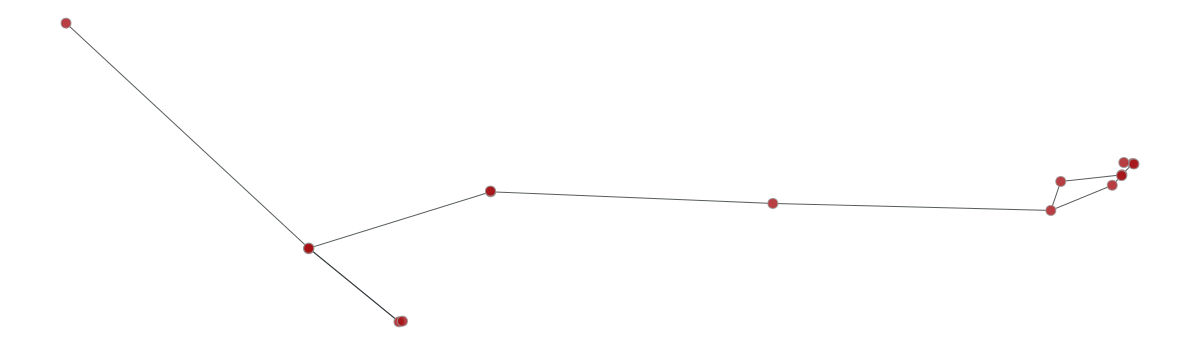

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1edf62c10, at 0x1ee2b6b50>

In [515]:
graph_draw(min_component_subgraph, pos=new_pos, vertex_size=5)

In [469]:
new_pos = g.vp.position.copy()


In [474]:
new_pos[0][0]

42.54359

In [486]:
for i, pos in enumerate(g.vp.position):
    new_pos[i] = (pos[1], -1 * pos[0])

In [ ]:
component_views = {}
for label in range(hist.shape[0]):
    # Extract the subgraph for the current component
    subgraph = GraphView(g, vfilt=components.a == label)
    
    # Add the subgraph to the dictionary
    component_views[label] = subgraph

In [ ]:
g.vertex_properties['position'][74198]

In [ ]:
usa[(usa['coords_one'] == "-111.1079245, 34.6581138") | (usa['coords_two'] == "-111.1079245, 34.6581138")]

In [ ]:
usa[(usa['coords_one'] == "-110.6899811, 35.0229279") | (usa['coords_two'] == "-110.6899811, 35.0229279")]

In [ ]:
usa.tail()

In [ ]:
np.unique(label_components(g)[1])

In [ ]:
g_sample = sample_graph(g, proportion=.005)

In [ ]:
g = Graph()

vprop_pos = g.new_vertex_property("vector<double>")
eprop_voltage = g.new_edge_property("double")
eprop_length = g.new_edge_property("double")

# Add vertices and properties
vertices = {}
for i, row in usa.iterrows():
    v1 = row['coords_one']
    v2 = row['coords_two']
    edge = g.add_edge(v1, v2)
    vprop_pos[v1] = [float(v1[0]), float(v1[1])]
    vprop_coords_two[coords_one] = [float(v2[0]), float(v2[1])]
    vertices[i] = coords_one

# Add edges and properties
for i, row in usa.iterrows():
    coords_one = vertices[i]
    coords_two = vertices[i]
    edge = g.edge(coords_one.source(), coords_two.target())
    eprop_voltage[edge] = row['VOLTAGE']
    eprop_length[edge] = row['SHAPE_Length']

# Set properties to the graph
g.vertex_properties['coords_one'] = vprop_coords_one
g.vertex_properties['coords_two'] = vprop_coords_two
g.edge_properties['voltage'] = eprop_voltage
g.edge_properties['length'] = eprop_length

In [ ]:
data = usa[['ID', 'TYPE', 'VOLTAGE', 'VOLT_CLASS', 'SHAPE_Length', 'coords_one', 'coords_two']].to_dict()

In [ ]:
edge_list = zip(data['coords_one'].values(), data['coords_two'].values())

In [ ]:
g = Graph(edge_list, hashed=True)

In [ ]:
np.unique(label_components(g)[1])

In [ ]:
list(g.vp.ids)

In [ ]:
pos = g.new_vertex_property('vector<double>')

In [ ]:
g.get_edges()

In [ ]:
range(1, 1+len(data['coords_one']))

In [ ]:
g = Graph(directed=False)

# Define properties
vprop_coords_one = g.new_vertex_property("vector<double>")
vprop_coords_two = g.new_vertex_property("vector<double>")
eprop_voltage = g.new_edge_property("double")
eprop_length = g.new_edge_property("double")

# Add vertices and properties
vertices = {}
for i, row in df.iterrows():
    v1 = row['coords_one'].split(', ')
    v2 = row['coords_two'].split(', ')
    coords_one = g.add_edge(g.vertex(i), g.vertex(i))
    vprop_coords_one[coords_one] = [float(v1[0]), float(v1[1])]
    vprop_coords_two[coords_one] = [float(v2[0]), float(v2[1])]
    vertices[i] = coords_one

# Add edges and properties
for i, row in df.iterrows():
    coords_one = vertices[i]
    coords_two = vertices[i]
    edge = g.edge(coords_one.source(), coords_two.target())
    eprop_voltage[edge] = row['VOLTAGE']
    eprop_length[edge] = row['SHAPE_Length']

# Set properties to the graph
g.vertex_properties['coords_one'] = vprop_coords_one
g.vertex_properties['coords_two'] = vprop_coords_two
g.edge_properties['voltage'] = eprop_voltage
g.edge_properties['length'] = eprop_length

# Print the graph
print(g)

In [ ]:
list(g.vertices())

In [ ]:
for idx, row in usa.iterrows():
    geometry = row['geometry']
    if geometry.geom_type == 'MultiLineString':
        for line_string in geometry.geoms:
            # Use the first and last points as nodes
            start_node = graph.add_vertex()
            end_node = graph.add_vertex()

            # Calcuyyyyyye the length of the LineString and use it as the weight
            length = line_string.length

            # Add nodes and edges to the graph with weight
            pos[start_node] = line_string.coords[0]
            pos[end_node] = line_string.coords[-1]

            edge = graph.add_edge(start_node, end_node)
            weight[edge] = length
            voltage[edge] = row['VOLTAGE']
    elif geometry.geom_type == 'LineString':
        # Use the first and last points as nodes
        start_node = graph.add_vertex()
        end_node = graph.add_vertex()

        # Calcuyyyyyye the length of the LineString and use it as the weight
        length = geometry.length

        # Add nodes and edges to the graph with weight
        pos[start_node] = geometry.coords[0]
        pos[end_node] = geometry.coords[-1]

        edge = graph.add_edge(start_node, end_node)
        weight[edge] = length
        voltage[edge] = row['VOLTAGE']

graph.save('new_transmission_lines.gt.gz')

In [ ]:
graph.edge_properties, graph.vertex_properties

In [ ]:
graph = load_graph('new_transmission_lines.gt.gz')

In [ ]:
graph.edge_properties, graph.vertex_properties

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString
from graph_tool.all import Graph, graph_draw
import random


# Create an undirected graph
graph = Graph(directed=False)

# Add property for edge voltages
voltages = graph.new_edge_property("int")

# Add nodes to the graph and set initial layout positions based on GeoJSON coordinates
node_dict = {}
pos = graph.new_vertex_property("vector<double>")
graph.vp.pos = pos  # Set pos as a vertex property of the graph
graph.ep.voltage = voltages

for i, row in usa.iterrows():
    v = graph.add_vertex()
    node_dict[row['ID']] = v

    # Set initial layout position based on GeoJSON coordinates
    if isinstance(row['geometry'], MultiLineString):
        for line in list(row['geometry'].geoms):
            coords = list(line.coords)
            pos[v] = coords[0][0], -1 * coords[0][1]  # Set initial position to the first coordinate in the line
            for coord in coords[1:]:
                v = graph.vertex(node_dict[row['ID']])
                e = graph.add_edge(v, graph.vertex(node_dict[row['ID']]))
                voltages[e] = row['VOLTAGE']
    elif isinstance(row['geometry'], LineString):
        coords = list(row['geometry'].coords)
        pos[v] = coords[0][0], -1 * coords[0][1]  # Set initial position to the first coordinate in the LineString
        for coord in coords[1:]:
            v = graph.vertex(node_dict[row['ID']])
            e = graph.add_edge(v, graph.vertex(node_dict[row['ID']]))
            voltages[e] = row['VOLTAGE']

graph.save('transmission_lines.gt.gz')

In [ ]:
remove_parallel_edges(graph)

In [ ]:
graph = load_graph('new_transmission_lines.gt.gz')

In [ ]:
graph

In [ ]:
np.random.choice(graph.get_vertices())

In [ ]:
usa['geometry'].apply(lambda x: x.geom_type).value_counts()

In [ ]:
usa['geometry'].iloc[1].geoms[0].coords[0], usa['geometry'].iloc[1].geoms[0].coords[-1]

In [ ]:
usa['coords_one'], usa['coords_two'] = usa['geometry'].apply(lambda x: x.geoms[0].coords[0]), usa['geometry'].apply(lambda x: x.geoms[0].coords[-1])

In [ ]:
usa.head()

In [ ]:
import pandas as pd
subset = usa[['OBJECTID', 'VOLTAGE', 'coords_one', 'coords_two', 'geometry']]
subset.merge(right=subset, how='inner', left_on=['coords_one'], right_on=['coords_one'])

In [ ]:
merged_df = pd.merge(subset, subset, left_on=['coords_one', 'coords_two'], right_on=['coords_two', 'coords_one'], how='outer')

# Filter out rows where the vertices are the same (excluding self-connections)
result_df = merged_df[merged_df['coords_one_x'] != merged_df['coords_two_y']]

# Drop duplicate columns and reset index
result_df = result_df[['coords_one_x', 'coords_two_x']].drop_duplicates().reset_index(drop=True)

# Rename columns for clarity
result_df.columns = ['coords_one', 'coords_two']

In [ ]:
def sample_graph(graph, num_steps = None, proportion = None):
    assert num_steps or proportion
    assert not (num_steps and proportion)

    if proportion:
        num_steps = len(graph.get_vertices() * proportion)

    print(num_steps)

    edges = set()
    vertices = set()

    edge_filter = graph.new_edge_property("bool")
    edge_filter.a = False

    vertex_filter = graph.new_vertex_property("bool")
    vertex_filter.a = False

    vertex = np.random.choice(list(graph.vertices()))
    vertex_filter[vertex] = True
    vertices.add(vertex)

    for _ in range(num_steps):
        edge = random.choice(list(vertex.out_edges()))
        print(edge)
        edge_filter[edge] = True
        vertex = edge.target()
        print(vertex)
        vertex_filter[vertex] = True

        vertices.add(vertex)
        edges.add(edge)

    print(list(vertex_filter))
    print(list(edge_filter))
    
    return GraphView(graph, vfilt=vertex_filter, efilt=edge_filter)

In [ ]:
subgraph = sample_graph(graph, proportion=.05)

In [ ]:
list(subgraph.vertices())

In [ ]:
random.choice(list(vertex.out_edges())).target()

In [ ]:
vertex = random.choice(list(graph.vertices()))

In [ ]:
vertex

In [ ]:
list(vertex.out_edges())

In [ ]:
num_vertices_to_sample = int(0.05 * graph.num_vertices())

# Randomly sample vertices
sampled_vertices = random.sample(list(graph.vertices()), num_vertices_to_sample)

vertex_filter = graph.new_vertex_property("bool")
vertex_filter.a = False
for vertex in sampled_vertices:
    vertex_filter[vertex] = True

# Collect edges connected to sampled vertices
sampled_edges = set()
for vertex in sampled_vertices:
    for edge in vertex.out_edges():
        sampled_edges.add(edge)

edge_filter = graph.new_edge_property("bool")
edge_filter.a = False
for edge in sampled_edges:
    edge_filter[edge] = True

# Create a graph view with the sampled vertices and connected edges
subgraph = GraphView(graph, vfilt=vertex_filter, efilt=edge_filter)

subgraph

In [ ]:
len(sampled_edges)

In [ ]:
subgraph.save('new_sample_transmission_lines.gt.gz')

In [ ]:
subgraph = load_graph('new_sample_transmission_lines.gt.gz')

In [ ]:
graph_draw(subgraph, pos=subgraph.vp.pos, bg_color=[0,0,0,0])

In [ ]:
subgraph

In [ ]:
list(subgraph.vp.pos)

In [ ]:
eigval, eigvec = eigenvector(subgraph, subgraph.ep.voltage)

In [ ]:
show_config()